In [177]:
!pip install matplotlib 
!pip install pandas

In [178]:
import csv
import matplotlib.pyplot as plt
import random

stat_dump_interval_ms = 100
stat_dump_interval_s = stat_dump_interval_ms / 1000

def plot_client_results(output_file, axs, xlim):
    # Define the file path
    input_file_path = 'logs/client_stats.log'

    client_data = {}
    start_time = None

    # Open and read the CSV file
    with open(input_file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row

        for row in reader:
            timestamp_str, client_id, op_type, count, max_val, min_val, avg, p50, p90, p99, p999, _, _, _, _, _, _, _, _ = row
            timestamp_s = int(timestamp_str) / 1000
            if start_time is None:
                start_time = timestamp_s

            if client_id not in client_data:
                client_data[client_id] = {'Tput': [], '50': [], '99': [], '999': [], 'ts': []}

            multiplier = 1
            if op_type == 'INSERT_BATCH':
                multiplier = 86
            elif op_type == 'SCAN':
                multiplier = 100

            client_data[client_id]['Tput'].append(multiplier * int(count) * 1024 / (1024 * 1024) / stat_dump_interval_s)
            client_data[client_id]['50'].append(float(p50) / 1000)
            client_data[client_id]['99'].append(float(p99) / 1000)
            client_data[client_id]['999'].append(float(p999) / 1000)
            client_data[client_id]['ts'].append(timestamp_s)

    def plot_metric(metric, title, ylabel, fig_loc, ylim):
        plt.figure(figsize=(8, 5))
        for client_id, stats in client_data.items():
            time_points = [ts - start_time for ts in client_data[client_id]['ts']]
            data_points = [x for x in stats[metric]]
            axs[fig_loc[0]].plot(time_points, data_points, marker='o', label=f'Client {client_id}')
            with open(output_file, 'a') as outfile:
                outfile.write(f"client-{client_id}:metric-{metric}\n")
                outfile.write(f"time_points:{time_points}\n")
                outfile.write(f"data_points:{data_points}\n")

        if metric == 'Tput':
            # Get all the time points:
            all_time_points = [ts for client_id in client_data for ts in client_data[client_id]['ts']]
            all_time_points = sorted(list(set(all_time_points)))

            # For each time point, sum the client throughputs.
            client_tput_sums = []
            for ts in all_time_points:
                cur_sum = 0
                for client_id in client_data:
                    if ts in client_data[client_id]['ts']:
                        idx = client_data[client_id]['ts'].index(ts)
                        cur_sum += client_data[client_id]['Tput'][idx]
                client_tput_sums.append(cur_sum)
            all_time_points = [ts - start_time for ts in all_time_points]
            # axs[fig_loc[0]].plot(all_time_points, client_tput_sums, marker='o', label='Sum')

        axs[fig_loc[0]].set_title(title)
        axs[fig_loc[0]].set_xlabel('Time (s)')
        axs[fig_loc[0]].set_xlim(xlim)
        # axs[fig_loc[0]].set_ylim(0, 40)
        axs[fig_loc[0]].set_ylabel(ylabel)
        axs[fig_loc[0]].legend()
        axs[fig_loc[0]].grid(True)
        # axs[fig_loc[0]].set_ylim(-2, ylim)

    # Plotting each metric
    plot_metric('Tput', 'Client Throughput', 'MB/s', (0, 0), 550)
    plot_metric('50', 'Latency: 50p', '(ms)', (1, 0), 25)
    plot_metric('99', 'Latency: 99p', '99th Percentile (ms)', (2, 0), 2000)
    return start_time


In [179]:
import matplotlib.pyplot as plt
import re
from datetime import datetime

def plot_memtable_stats(output_file, axs, start_time, xlim, fig_loc):
    # Define the file paths
    input_file_path = '/mnt/rocksdb/ycsb-rocksdb-data/LOG'

    cf_data = {}

    # Compile the regular expressions for matching lines
    
    # memtable_regex = re.compile(r'^memtables,([^,]+),(\d+),(\d+)MB$')
    # memtable_regex = re.compile(r'^memtables,([^,]+),(\d+),(\d+)MB$')
    memtable_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}).\d{6} \d+ .*.cc:\d+\] mt,([^,]+),([^,]+).*')


    def timestamp_to_seconds(timestamp_str):
        timestamp_str = timestamp_str.strip()
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    # Open and read the input file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            memtable_match = memtable_pattern.match(line)
            if not memtable_match:
                continue
                
            ts, cf_name, operation = memtable_match.group(1, 2, 3)
            operation = operation.strip()
            if cf_name not in cf_data:
                # Assume 0 active memtables to start. Thus, this is basically tracking imm tables pending flush
                cf_data[cf_name] = {"counts" : [0], "ts" : [start_time]}
            cf_data[cf_name]["ts"].append(timestamp_to_seconds(ts))
            if operation == 'add':
                cf_data[cf_name]["counts"].append(cf_data[cf_name]["counts"][-1] + 1)
            elif operation == 'remove':
                cf_data[cf_name]["counts"].append(cf_data[cf_name]["counts"][-1] - 1)
            else:
                print('invalid memtable operation name')
                
                
    def plot_metric(metric, ax, colors):
        idx = 0
        for cf_name, stats in cf_data.items():
            data_points = [int(x) for x in stats[metric]]
            time_points = [ts - start_time for ts in stats["ts"]]

            # Ignore initial memtable init.
            # ax.plot(time_points, data_points, marker='o', label=f'{cf_name}', color=colors[idx])
            if cf_name == 'default':
                label = 'Client 0'
            else:
                label = 'Client ' + cf_name[-1]
            ax.plot(time_points, data_points, marker='o', label=f'{label}')
            with open(output_file, 'a') as outfile:
                outfile.write(f"cf-{cf_name}:metric-{metric}\n")
                outfile.write(f"time_points:{time_points}\n")
                outfile.write(f"data_points:{data_points}\n")


            idx += 1
        ax.set_xlabel('Time (s)')
            
    # Plotting each metric
    plot_metric('counts', axs[fig_loc[0]], ['blue', 'lightblue'])
    # plot_metric('counts', axs[fig_loc[0]], ['orange', '#ffd580'])
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_title("Memtable Stats")
    axs[fig_loc[0]].legend(loc='upper left')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_ylabel('Count')

    # size_ax = axs[fig_loc[0]].twinx()
    # plot_metric('table_sizes', size_ax, ['blue', 'lightblue'])
    # size_ax.legend(loc='upper right')
    # size_ax.set_ylabel('Memtables Size (MB)')
    # size_ax.set_ylim(0,128)
    # plt.subplots_adjust(right=0.85)

def plot_level_stats(output_file, axs, fig_loc):
    # Define the file paths
    input_file_path = '/mnt/rocksdb/ycsb-rocksdb-data/LOG'

    level_data = {}
    level_hit_pattern = re.compile(r'rocksdb.l(0|1|2|3).hit COUNT : (\d+).*')

    hits = [None, None, None, None]
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            level_hit_match = level_hit_pattern.match(line)
            if not level_hit_match:
                continue
            level, new_hits = level_hit_match.group(1, 2)
            # Always overwrite.
            hits[int(level)] = int(new_hits)

    cumulative_hits = []
    cumulative_count = 0
    for hit in hits:
        cumulative_count += hit
        cumulative_hits.append(cumulative_count)
    cumulative_hits_prop = [x / cumulative_count * 100 for x in cumulative_hits]
    
    axs[fig_loc[0]].plot(["l0", "l1", "l2", "l3"], cumulative_hits_prop, marker='o')

    axs[fig_loc[0]].set_title("Level Hits CDF")
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_ylabel('Cumulative Hits (%)')

    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-level_hits\n")
        outfile.write(f"data_points:{cumulative_hits_prop}\n")


In [180]:
import matplotlib.pyplot as plt
import re
import json
from datetime import datetime

def get_compaction_color(cf_name, level):
    # Red
    if cf_name == "cf15":
        if level == 1:
            return "#fc9598"
        elif level == 2:
            return "#ff696e"
        elif level == 3:
            return "#f02225"
        elif level == 4:
            return "#cf1d20"
        elif level == 5:
            return "#ab1619"
        elif level == 6:
            return "#851114"
        else:
        # elif level == 7:
            return "#610c0e"
    # Blue
    elif cf_name == "cf2":
        if level == 1:
            return "#95c2fc"
        elif level == 2:
            return "#699eff"
        elif level == 3:
            return "#225bf0"
        elif level == 4:
            return "#1d4bcf"
        elif level == 5:
            return "#1638ab"
        elif level == 6:
            return "#112985"
        else:
            # elif level == 7:
            return "#0c1d61"
    # Orange
    elif cf_name == "cf3":
        if level == 1:
            return "#ffd1b3"  # light orange
        elif level == 2:
            return "#ffa366"  # medium light orange
        elif level == 3:
            return "#ff7519"  # medium orange
        elif level == 4:
            return "#cc5c14"  # medium dark orange
        elif level == 5:
            return "#993d0f"  # dark orange
        elif level == 6:
            return "#66260a"  # darker orange
        else:
            # elif level == 7:
            return "#331305"  # darkest orange
    else:
        if level == 1:
            return "#c9fcb2"  # light green
        elif level == 2:
            return "#9ff987"  # medium light green
        elif level == 3:
            return "#75f35d"  # medium green
        elif level == 4:
            return "#58d740"  # medium dark green
        elif level == 5:
            return "#46b334"  # dark green
        elif level == 6:
            return "#328028"  # darker green
        else:
            # elif level == 7:
            return "#21571d"  # darkest green


def plot_rocksdb_events(output_file, axs, experiment_start_time, xlim, fig_loc):
    # log_file_path = '/mnt/multi-cf2/ycsb-rocksdb-data-2/LOG'
    # log_file_path = '/mnt/multi-cf/ycsb-rocksdb-data/LOG'
    log_file_path = '/mnt/rocksdb/ycsb-rocksdb-data/LOG'
    flush_regex = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}) \d+ \[/flush_job\.cc:\d+\] \[(.*?)\] \[JOB \d+\] Flush: (\d+) microseconds, \d+ cpu microseconds, (\d+) bytes'
    )
    l0_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stalling writes because we have \d+ level-0 files rate (\d+)')
    memtable_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stalling writes because we have \d+ immutable memtables.*rate (\d+)')
    pending_compaction_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stalling writes because of estimated pending compaction bytes \d+ rate (\d+)')
    memtable_stop_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[([^,]+)\] Stopping writes because we have \d+ immutable memtables.*')

    compaction_regex = re.compile(r'.*EVENT_LOG_v1 (.*)$')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    def timestamp_to_micros(timestamp_str):
        timestamp_format = '%Y/%m/%d-%H:%M:%S.%f'
        dt = datetime.strptime(timestamp_str, timestamp_format)
        epoch = datetime(1970, 1, 1)
        micros_since_epoch = int((dt - epoch).total_seconds() * 1000000)
        return micros_since_epoch

    # Initialize lists for all events
    l0_stalls, memtable_stalls, pending_compaction_stalls = [], [], []
    compaction_data = {}
    flush_data = {}
    memtable_stops = []

    # Process the log file for stall, flush, and compaction events
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # L0 and Memtable Stalls
            l0_match = l0_stall_pattern.search(line)
            if l0_match:
                timestamp_str, cf_name, rate = l0_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                l0_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_match = memtable_stall_pattern.search(line)
            if memtable_match:
                timestamp_str, cf_name, rate = memtable_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_stop_match = memtable_stop_pattern.search(line)
            if memtable_stop_match:
                timestamp_str, cf_name = memtable_stop_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stops.append((timestamp_micros, cf_name))

            pending_compact_match = pending_compaction_stall_pattern.search(line)
            if pending_compact_match:
                timestamp_str, cf_name, rate = pending_compact_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                pending_compaction_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            # Flush Events
            flush_match = flush_regex.match(line)
            if flush_match:
                timestamp_str, cf_name, flush_microseconds, flush_bytes = flush_match.groups()
                start_time_seconds = timestamp_to_seconds(timestamp_str) - int(flush_microseconds) / 1e6
                rate_MB_s = (int(flush_bytes) / int(flush_microseconds)) * 1e6 / (1024**2)
                if cf_name not in flush_data:
                    flush_data[cf_name] = []
                flush_data[cf_name].append((start_time_seconds, rate_MB_s, int(flush_microseconds)/1e6))
            
            # Compaction Events
            compaction_match = compaction_regex.match(line)
            if compaction_match:
                json_str = compaction_match.group(1)
                try:
                    event_data = json.loads(json_str)
                    if event_data['event'] != 'compaction_finished':
                        continue
                    end_time_seconds = event_data['time_micros'] / 1e6
                    start_time_seconds = end_time_seconds - event_data['compaction_time_micros'] / 1e6
                    # start_time_seconds = event_data['time_micros'] / 1e6
                    # end_time_seconds = start_time_seconds + event_data['compaction_time_micros'] / 1e6
                    read_rate = event_data['read_rate']
                    write_rate = event_data['write_rate']
                    output_level = event_data['output_level']
                    cf_name = event_data['cf_name']
                    if cf_name not in compaction_data:
                        compaction_data[cf_name] = []
                    compaction_data[cf_name].append((start_time_seconds, end_time_seconds, read_rate, write_rate, output_level))
                except:
                    print("Compaction json error")

    # Determine the overall start time
    print(f'Exp start time: {experiment_start_time}')

    # Convert L0 and Memtable timestamps to seconds since experiment start
    l0_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in l0_stalls]
    l0_rates = [int(rate) for _, rate in l0_stalls]

    memtable_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in memtable_stalls]
    memtable_rates = [int(rate) for _, rate in memtable_stalls]

    pending_compaction_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in pending_compaction_stalls]
    pending_compaction_rates = [int(rate) for _, rate in pending_compaction_stalls]

    # Plotting
    # plt.figure(figsize=(8, 5))

    # Plot L0 and Memtable Stalls
    axs[fig_loc[0]].scatter(l0_timestamps, l0_rates, label='L0 Stalls', color='blue', s=10)
    axs[fig_loc[0]].scatter(memtable_timestamps, memtable_rates, label='Memtable Stalls', color='purple', s=10)
    axs[fig_loc[0]].scatter(pending_compaction_timestamps, pending_compaction_rates, label='Pend Compact Stalls', color='orange', s=10)

    # TODO(tgriggs): Add stops to this
    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-L0_stalls\n")
        outfile.write(f"time_points:{l0_timestamps}\n")
        outfile.write(f"data_points:{l0_rates}\n")

        outfile.write(f"metric-memtable_stalls\n")
        outfile.write(f"time_points:{memtable_timestamps}\n")
        outfile.write(f"data_points:{memtable_rates}\n")

        outfile.write(f"metric-pending_compaction_stalls\n")
        outfile.write(f"time_points:{pending_compaction_timestamps}\n")
        outfile.write(f"data_points:{pending_compaction_rates}\n")
    
   
    # Plot Flush Events
    for cf_name in flush_data:
        if cf_name == "cf15":
            color = 'red'
            label = 'Client 15 Flush'
        elif cf_name == 'cf2':
            color = 'blue'
            label = 'Client 1 Flush'
        elif cf_name == 'cf3':
            color = 'orange'
            label = 'Client 2 Flush'
        else:
            color = 'green'
            label = 'Client 3 Flush'
        for start_time, rate, duration in flush_data[cf_name]:
            # Determine if this is the first occurrence of this cf_name for labeling
            # is_first = flush_data.index((start_time, rate, duration, cf_name)) == 0
            is_first = flush_data[cf_name].index((start_time, rate, duration)) == 0
            # is_first = compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0

            # Plotting with custom dashed line pattern for stripes
            axs[fig_loc[0]].hlines(rate, start_time - experiment_start_time, 
                                (start_time + duration) - experiment_start_time, 
                                colors=color, linewidth=4, 
                                linestyles=(0, (5, 10)) if is_first else 'solid', 
                                label=label if is_first else "")

    # Plot Compaction Events
    for cf_name in compaction_data:
        for start_time, end_time, read_rate, write_rate, output_level in compaction_data[cf_name]:
            # TODO(tgriggs): CHANGE 3 to ORANGE to match defaults
            color = get_compaction_color(cf_name, output_level)
            if cf_name == 'default':
                label = 'Client 0 Compaction'
            else:
                label = 'Client ' + cf_name[-1] + ' Compaction'
            axs[fig_loc[0]].hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label=label if compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
            # axs[fig_loc[0]].hlines(read_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label=label if compaction_data[cf_name].index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
    
    # memtable_stop_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros in memtable_stops]
    memtable_stops_cf_seen = set()
    for i in range(len(memtable_stops)):
        memtable_stop_ts, cf_name = memtable_stops[i]
        memtable_stop_ts = (memtable_stop_ts / 1e6) - experiment_start_time
        if i == 0:
        # if cf_name not in memtable_stops_cf_seen:
            axs[fig_loc[0]].axvline(x=memtable_stop_ts, color='brown', linestyle='--', linewidth=0.5, label = 'Memtable Stops', alpha=0.5)
            memtable_stops_cf_seen.add(cf_name)
        else:
            axs[fig_loc[0]].axvline(x=memtable_stop_ts, color='brown', linestyle='--', linewidth=0.5, alpha=0.5)

    with open(output_file, 'a') as outfile:
        outfile.write(f"metric-flush\n")
        all_cfs = []
        all_rates = []
        all_start_points = []
        all_end_points = []
        for cf in flush_data:
            for start_time, rate, duration in flush_data[cf]:
                all_cfs.append(cf)
                all_rates.append(rate)
                all_start_points.append(start_time)
                all_end_points.append(start_time + duration)
        outfile.write(f"cf_names:{all_cfs}\n")
        outfile.write(f"reates:{all_rates}\n")
        outfile.write(f"start_points:{[start_time - experiment_start_time for start_time in all_start_points]}\n")
        outfile.write(f"end_points:{[end_time - experiment_start_time for end_time in all_end_points]}\n")

        outfile.write(f"metric-compaction\n")
        all_cfs = []
        all_read_rates = []
        all_write_rates = []
        all_start_points = []
        all_end_points = []
        for cf in compaction_data:
            for start_time, end_time, read_rate, write_rate, _ in compaction_data[cf]:
                all_read_rates.append(read_rate)
                all_write_rates.append(write_rate)
                all_start_points.append(start_time)
                all_end_points.append(end_time)
                all_cfs.append(cf)
        outfile.write(f"cf_names:{all_cfs}\n")
        outfile.write(f"read_rates:{all_read_rates}\n")
        outfile.write(f"write_rates:{all_write_rates}\n")
        outfile.write(f"start_points:{[start_time - experiment_start_time for start_time in all_start_points]}\n")
        outfile.write(f"end_points:{[end_time - experiment_start_time for end_time in all_end_points]}\n")
        
        outfile.write(f"metric-memtable_stops\n")
        outfile.write(f"time_points:{memtable_stops}\n")
        

    axs[fig_loc[0]].set_title('Database Operations Over Time')
    axs[fig_loc[0]].set_xlabel('Time (seconds since start of experiment)')
    axs[fig_loc[0]].set_ylabel('MB/s')
    axs[fig_loc[0]].set_xlim(xlim)
    # axs[fig_loc[0]].set_ylim(0, 450)
    axs[fig_loc[0]].legend()
    axs[fig_loc[0]].grid(True)

In [181]:
# Overall throughputs (client + system)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time

max_read_tput = 700
max_read_iops = 180000
max_write_tput = 400
max_write_iops = 100000

def timestamp_to_seconds(timestamp_str):
  timestamp = datetime.strptime(timestamp_str.rstrip(), '%Y-%m-%d %H:%M:%S.%f')
  epoch = datetime(1970, 1, 1)
  return (timestamp - epoch).total_seconds()

def plot_overall_tputs(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")

  # print(f"Timestamp: {timestamp_to_seconds(df_from_csv['Timestamp'][0])}")

  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  # Plotting
  # axs[fig_loc[0]].figure(figsize=(10, 6))
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rMB/s"], label='Read MB/s', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wMB/s"], label='Write MB/s', marker='o', color='tab:red')

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rMB_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["rMB/s"].tolist()}\n")

    outfile.write(f"metric-wMB_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["wMB/s"].tolist()}\n")

  axs[fig_loc[0]].set_title('SSD Throughput Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('MB/s')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0, 520)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  # # Creating a second y-axis
  # ax2 = axs[fig_loc[0]].twinx()
  # # Plotting on the secondary y-axis
  # ax2.plot(time_seconds, df_from_csv["rMB/s"]/max_read_tput, label='Read Util', marker='x', linestyle='--', color='tab:green')
  # ax2.plot(time_seconds, df_from_csv["wMB/s"]/max_write_tput, label='Write Util', marker='+', linestyle='--', color='tab:red')
  # ax2.set_ylabel('Utilization (based on tput)')
  # ax2.legend(loc='upper right')
  # ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rMB_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["rMB/s"]/max_read_tput).tolist()}\n")

    outfile.write(f"metric-wMB_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["wMB/s"]/max_write_tput).tolist()}\n")

def plot_overall_iops(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r/s"], label='Read IOPS', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["w/s"], label='Write IOPS ', marker='o', color='tab:red')

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rIOP_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["r/s"].tolist()}\n")

    outfile.write(f"metric-wIOP_rate\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["w/s"].tolist()}\n")

  axs[fig_loc[0]].set_title('SSD IOPS Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('IOPS')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,16)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

  # Creating a second y-axis
  ax2 = axs[fig_loc[0]].twinx()
  # Plotting on the secondary y-axis
  ax2.plot(time_seconds, df_from_csv["r/s"]/max_read_iops, label='Read IOPS Util', marker='x', linestyle='--', color='tab:green')
  ax2.plot(time_seconds, df_from_csv["w/s"]/max_write_iops, label='Write IOPS Util', marker='+', linestyle='--', color='tab:red')
  ax2.set_ylabel('Utilization (based on iops)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-rIOP_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["r/s"]/max_read_iops).tolist()}\n")

    outfile.write(f"metric-wIOP_util\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{(df_from_csv["w/s"]/max_write_iops).tolist()}\n")

def plot_io_waittimes(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["r_await"], label='Read Await (per req)', marker='o', color='tab:green')
  # axs[fig_loc[0]].plot(time_seconds, df_from_csv["w_await"], label='Write Await (per req)', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('IO Wait Times (queueing + servicing)')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Wait Time (ms)')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper left')
  axs[fig_loc[0]].grid(True)

  ax2 = axs[fig_loc[0]].twinx()
  ax2.plot(time_seconds, [df_from_csv["r_await"][i] / df_from_csv["rareq-sz"][i] if df_from_csv["rareq-sz"][i] > 0 else df_from_csv["r_await"][i] for i in range(len(df_from_csv["r_await"]))], label='Read Await (per KB)', marker='x', color='tab:green')
  # ax2.plot(time_seconds, [df_from_csv["w_await"][i] / df_from_csv["wareq-sz"][i] if df_from_csv["wareq-sz"][i] > 0 else df_from_csv["w_await"][i]   for i in range(len(df_from_csv["w_await"]))], label='Write Await (per KB)', marker='x', color='tab:red')

  ax2.set_ylabel('IO Wait Times per KB')
  ax2.legend(loc='upper right')
  plt.subplots_adjust(right=0.85)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-r_await\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["r_await"].tolist()}\n")

    outfile.write(f"metric-r_await_per_kb\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{[df_from_csv["r_await"][i] / df_from_csv["rareq-sz"][i] if df_from_csv["rareq-sz"][i] > 0 else df_from_csv["r_await"][i] for i in range(len(df_from_csv["r_await"]))]}\n")

def plot_io_reqsize(output_file, axs, start_time_shift, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")
  time_seconds = np.arange(len(df_from_csv))
  time_seconds = [x + start_time_shift for x in time_seconds]

  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rareq-sz"], label='Avg Read Size', marker='o', color='tab:green')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wareq-sz"], label='Avg Write Size', marker='o', color='tab:red')

  axs[fig_loc[0]].set_title('Avg IO Sizes')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('Size (KB)')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,1)
  axs[fig_loc[0]].legend(loc='upper right')
  axs[fig_loc[0]].grid(True)

  with open(output_file, 'a') as outfile:
    outfile.write(f"metric-r_size\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["rareq-sz"].tolist()}\n")

    outfile.write(f"metric-w_size\n")
    outfile.write(f"time_points:{time_seconds}\n")
    outfile.write(f"data_points:{df_from_csv["wareq-sz"].tolist()}\n")

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_cpu_util(output_file, axs, start_time_shift, xlim, fig_loc):
    df = pd.read_csv("mpstat_results.csv")
    
    # Assuming core values are strings and stripping any potential whitespace
    df['core'] = df['core'].map(lambda x: x.strip())
    df_filtered = df[df['core'].isin(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15'])].copy()

    # Convert metrics to float
    df_filtered['usr'] = df_filtered['usr'].map(lambda x: float(x))
    df_filtered['sys'] = df_filtered['sys'].map(lambda x: float(x))
    df_filtered['iowait'] = df_filtered['iowait'].map(lambda x: float(x))
    df_filtered['soft'] = df_filtered['soft'].map(lambda x: float(x))
    df_filtered['idle'] = df_filtered['idle'].map(lambda x: float(x))

    # Calculate the sum of iowait and idle for each row
    df_filtered['sum_iowait_idle'] = df_filtered['iowait'] + df_filtered['idle']
    
    # For plotting purposes, assuming each row represents a sequential time unit
    time_seconds = np.arange(len(df_filtered))
    time_seconds = [x + start_time_shift for x in time_seconds]

    # Group by core and plot each group
    for core, group in df_filtered.groupby('core'):
        # Calculate the index for each group based on its length
        group_index = list(np.arange(len(group)))
        axs[fig_loc[0]].plot(group_index, [100 - x for x in group['sum_iowait_idle']], label=f'Core {core} idle+iowait')
        with open(output_file, 'a') as outfile:
            outfile.write(f"metric-cpu_util:core-{core}\n")
            outfile.write(f"time_points:{group_index}\n")
            outfile.write(f"data_points:{[100 - x for x in group['sum_iowait_idle']]}\n")

    axs[fig_loc[0]].set_title('CPU Utilization (all but iowait and idle)')
    axs[fig_loc[0]].set_xlabel('Time (seconds)')
    axs[fig_loc[0]].legend(loc='upper right')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_ylim(-2, 102)


In [183]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_rsched_stats(output_file, axs, start_time_s, xlim, fig_loc):
    start_time_us = start_time_s * 1e6
    # Initialize lists to store the data for each client
    timestamps = defaultdict(list)  # Dictionary to store timestamps for each client
    memtables_data = defaultdict(lambda: ([], []))  # (list of values before '-', list of values after '-')
    writes_data = defaultdict(list)
    reads_data = defaultdict(list)

    # Function to parse a line and extract the data
    def parse_csv_row(row):
        timestamp, client_id, write_rate_limit_kbs, read_rate_limit_kbs, write_buffer_size_kb, max_write_buffer_number = row
        timestamp = (float(timestamp) - start_time_us) / 1e6
        client_id = int(client_id)
        timestamps[client_id].append(timestamp)
        memtables_data[client_id][0].append(int(max_write_buffer_number))
        memtables_data[client_id][1].append(int(write_buffer_size_kb) / 1024)
        writes_data[client_id].append(int(write_rate_limit_kbs) / 1024)
        reads_data[client_id].append(int(read_rate_limit_kbs) / 1024)

    # Read the CSV file
    csv_file = 'logs/resource_shares.log'  # Replace with your CSV file name
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            parse_csv_row(row)

    # Helper function to calculate total allocations
    def calculate_total(data):
        max_length = max(len(lst) for lst in data.values())
        total_allocation = [0] * max_length
        for lst in data.values():
            for i in range(len(lst)):
                total_allocation[i] += lst[i]
        return total_allocation

    # Calculate total allocations
    if len(writes_data) == 0 and len(reads_data) == 0 and len(memtables_data) == 0:
        return

    # Plot the memtables data with two different axes
    ax1 = axs[fig_loc[0]]
    min_length = min(len(data[0]) for data in memtables_data.values())
    cumulative_data = np.zeros(min_length)

    for client in sorted(memtables_data.keys()):
        time_axis = timestamps[client][:min_length]
        current_data = np.array(memtables_data[client][0][:min_length])
        new_cumulative_data = cumulative_data + current_data
        
        ax1.plot(time_axis, new_cumulative_data, label=f'Client {client} #table')
        ax1.fill_between(time_axis, cumulative_data, new_cumulative_data, alpha=0.3)
        
        cumulative_data = new_cumulative_data

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Max num memtables')
    ax1.set_title('Memtable Limits')
    ax1.legend(loc='upper left')
    ax1.set_xlim(xlim)

    # Plot the writes data for all clients
    ax2 = axs[fig_loc[1]]
    min_length = min(len(writes_data[client]) for client in writes_data)
    cumulative_data = np.zeros(min_length)

    for client in sorted(writes_data.keys()):
        time_axis = timestamps[client][:min_length]
        current_data = np.array(writes_data[client][:min_length])
        new_cumulative_data = cumulative_data + current_data
        
        ax2.plot(time_axis, new_cumulative_data, label=f'Client {client}')
        ax2.fill_between(time_axis, cumulative_data, new_cumulative_data, alpha=0.3)
        
        cumulative_data = new_cumulative_data

    ax2.set_title('IO Write Rate Limit')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('MB/s')
    ax2.legend()
    ax2.set_xlim(xlim)
    # ax2.set_ylim(5, 300)

    # Plot the reads data for all clients
    ax3 = axs[fig_loc[2]]
    min_length = min(len(reads_data[client]) for client in reads_data)
    cumulative_data = np.zeros(min_length)

    for client in sorted(reads_data.keys()):
        time_axis = timestamps[client][:min_length]
        current_data = np.array(reads_data[client][:min_length])
        new_cumulative_data = cumulative_data + current_data
        
        ax3.plot(time_axis, new_cumulative_data, label=f'Client {client}')
        ax3.fill_between(time_axis, cumulative_data, new_cumulative_data, alpha=0.3)
        
        cumulative_data = new_cumulative_data

    ax3.set_title('IO Read Rate Limit')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('MB/s')
    ax3.legend()
    ax3.set_xlim(xlim)

    plt.tight_layout()
    # plt.savefig(output_file)
    plt.show()


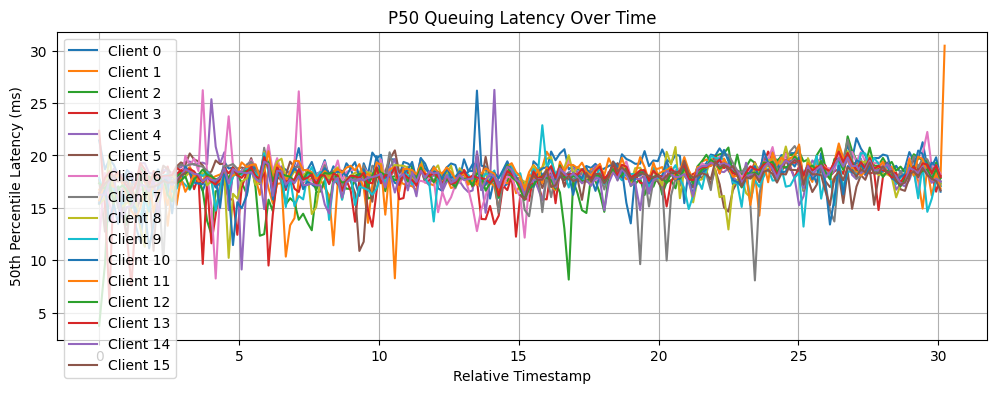

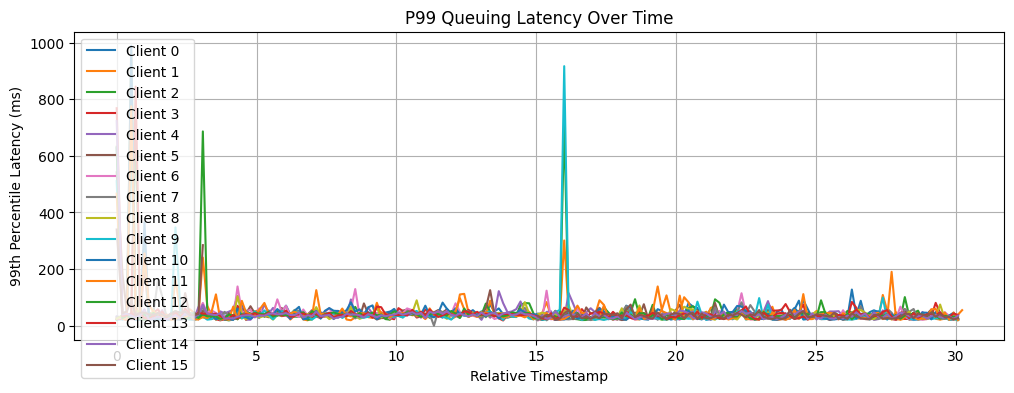

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'logs/client_stats.log'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Filter for op_type "QUEUE"
queue_data = data[data['op_type'] == 'QUEUE'].copy()

# Exclude client IDs '3' and '4'
# queue_data = queue_data[~queue_data['client_id'].isin([3, 4])]

# Adjust timestamps relative to the starting timestamp
queue_data['timestamp'] = (queue_data['timestamp'] - queue_data['timestamp'].min()) / 1000

# Create separate DataFrames for 50p and 99p latency
latency_50p = queue_data.pivot(index='timestamp', columns='client_id', values='50p')
latency_99p = queue_data.pivot(index='timestamp', columns='client_id', values='99p')

# Plot 50p latency
plt.figure(figsize=(12, 4))
for client_id in latency_50p.columns:
    plt.plot(latency_50p.index, latency_50p[client_id], label=f'Client {client_id}')
plt.title('P50 Queuing Latency Over Time')
plt.xlabel('Relative Timestamp')
plt.ylabel('50th Percentile Latency (ms)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 99p latency
plt.figure(figsize=(12, 4))
for client_id in latency_99p.columns:
    plt.plot(latency_99p.index, latency_99p[client_id], label=f'Client {client_id}')
plt.title('P99 Queuing Latency Over Time')
plt.xlabel('Relative Timestamp')
plt.ylabel('99th Percentile Latency (ms)')
plt.legend()
# plt.xlim(280, 340)
# plt.ylim(0, 4000)
plt.grid(True)
plt.show()


In [185]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_wbm_data(file_path):
    # Initialize a nested dictionary to store data for each client id
    client_data = defaultdict(lambda: {'global': [], 'steady': []})

    # Read the file and parse relevant lines
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("wbm"):
                parts = line.strip().split(',')
                if len(parts) == 7 and parts[3] == 'res':
                    # Process 'res' line with steady or global
                    try:
                        _, timestamp, client_id, operation, operation_size, current_value, steady_or_global = parts
                        timestamp = int(timestamp) / 1000  # Convert to seconds
                        client_id = int(client_id)
                        current_value = int(current_value) / (1024 * 1024)  # Convert to MB
                        steady_or_global = steady_or_global.strip()
                        if steady_or_global in ['steady', 'global']:
                            client_data[client_id][steady_or_global].append((timestamp, current_value))
                    except ValueError:
                        continue
                elif len(parts) == 8 and parts[3] == 'free':
                    # Process 'free' line with global:XXX and steady:YYY
                    try:
                        _, timestamp, client_id, operation, operation_size, current_value, global_str, steady_str = parts
                        timestamp = int(timestamp) / 1000
                        client_id = int(client_id)
                        # Extract the global and steady values
                        global_value = int(global_str.split(':')[1]) / (1024 * 1024)  # Convert to MB
                        steady_value = int(steady_str.split(':')[1]) / (1024 * 1024)  # Convert to MB
                        # Store the values
                        client_data[client_id]['global'].append((timestamp, global_value))
                        client_data[client_id]['steady'].append((timestamp, steady_value))
                    except (ValueError, IndexError):
                        continue
                else:
                    continue
            else:
                continue

    # Determine the start time of the experiment
    start_time = min(
        min((timestamps[0][0] for timestamps in client.values() if len(timestamps) > 0), default=float('inf'))
        for client in client_data.values()
    )

    # Adjust timestamps and convert to numpy arrays
    for client_id in client_data:
        for key in ['global', 'steady']:
            values = client_data[client_id][key]
            adjusted_values = [(timestamp - start_time, value) for timestamp, value in values]
            client_data[client_id][key] = np.array(adjusted_values)

    # Collect all timestamps
    all_timestamps = sorted(set(
        timestamp
        for client_values in client_data.values()
        for key in ['global', 'steady']
        for timestamp, _ in client_values[key]
    ))

    # Initialize latest values for each client and key
    latest_values = {client_id: {'global': 0, 'steady': 0} for client_id in client_data}
    total_usage_values = []
    sum_steady_values = []
    sum_global_values = []

    # Calculate per-client total usage and total usages
    for ts in all_timestamps:
        total_global = 0
        total_steady = 0
        total_usage = 0
        per_client_total_usage = {}
        for client_id in client_data:
            total_client_usage = 0
            for key in ['global', 'steady']:
                values = client_data[client_id][key]
                if len(values) == 0:
                    continue
                mask = values[:, 0] <= ts
                if np.any(mask):
                    latest_values[client_id][key] = values[mask, 1][-1]
                # Sum up the latest values
            # Sum per-client total usage
            total_client_usage = latest_values[client_id]['global'] + latest_values[client_id]['steady']
            per_client_total_usage[client_id] = total_client_usage
            total_usage += total_client_usage
            total_global += latest_values[client_id]['global']
            total_steady += latest_values[client_id]['steady']
        total_usage_values.append((ts, total_usage))
        sum_steady_values.append((ts, total_steady))
        sum_global_values.append((ts, total_global))

    # Convert total usage values to numpy arrays
    total_usage_values = np.array(total_usage_values)
    sum_steady_values = np.array(sum_steady_values)
    sum_global_values = np.array(sum_global_values)

    # Prepare per-client total usage arrays for plotting
    client_total_usage = {}
    for client_id in client_data:
        timestamps = []
        usage_values = []
        latest_values = {'global': 0, 'steady': 0}
        for ts in all_timestamps:
            for key in ['global', 'steady']:
                values = client_data[client_id][key]
                if len(values) == 0:
                    continue
                mask = values[:, 0] <= ts
                if np.any(mask):
                    latest_values[key] = values[mask, 1][-1]
            total_client_usage = latest_values['global'] + latest_values['steady']
            timestamps.append(ts)
            usage_values.append(total_client_usage)
        client_total_usage[client_id] = np.array([timestamps, usage_values])

    # Plot the data
    plt.figure(figsize=(12, 4))

    # Plot per-client total usage
    for client_id, data in client_total_usage.items():
        plt.plot(data[0], data[1], label=f"Client {client_id} Total Usage")

    # Plot summed lines
    plt.plot(total_usage_values[:, 0], total_usage_values[:, 1], label="All Clients Total Usage", color="black", linestyle="-", linewidth=2)
    plt.plot(sum_steady_values[:, 0], sum_steady_values[:, 1], label="Total Steady Usage", color="green", linestyle="--", linewidth=2)
    plt.plot(sum_global_values[:, 0], sum_global_values[:, 1], label="Total Global Usage", color="blue", linestyle=":", linewidth=2)

    # Add labels, legend, and title
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Usage (MB)")
    plt.title("Memtable Shares Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.ylim(0, 256)
    # plt.xlim(0, 25)

    # Show the plot
    plt.show()

# Call the function with the path to your file
file_path = "logs/memtable_stats.txt"  # Replace with your file's path
#plot_wbm_data(file_path)


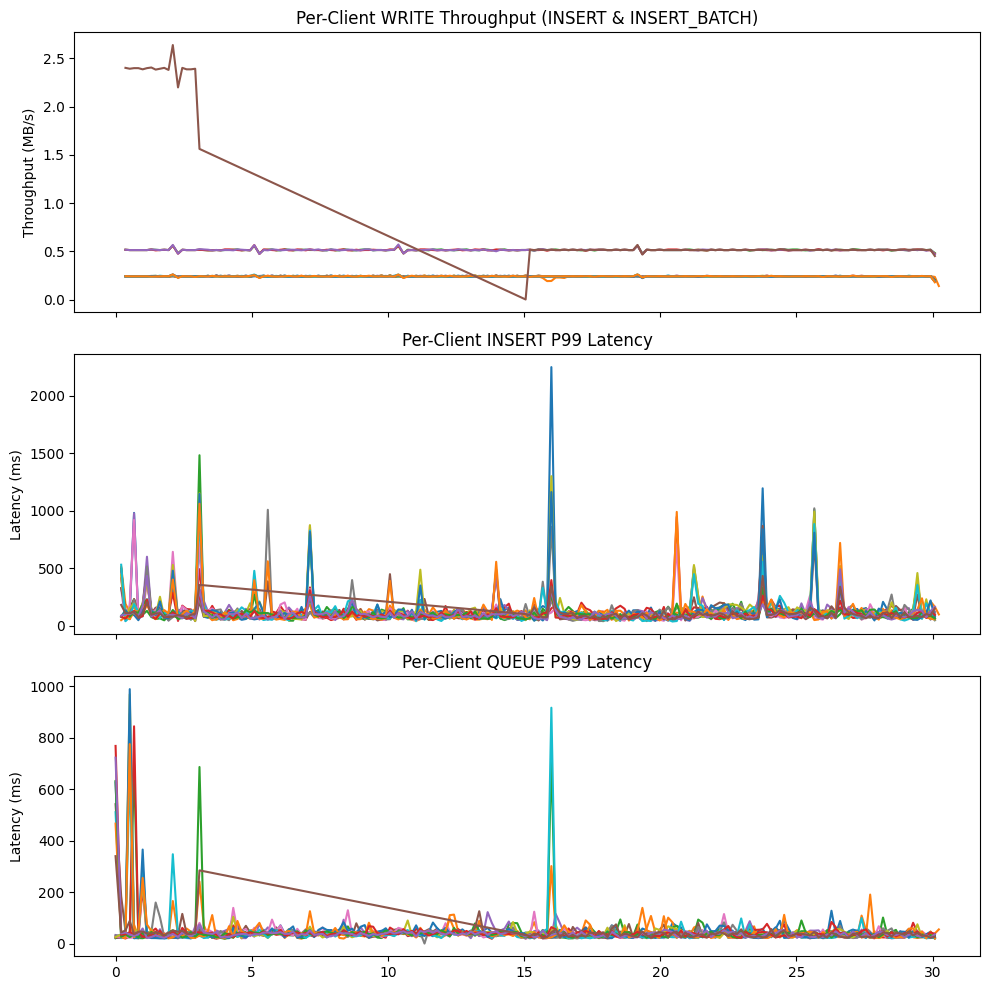

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuration: Operation sizes (in KB)
READ_SIZE_KB = 1  # Size of a single READ operation
INSERT_SIZE_KB = 1  # Size of a single INSERT operation
INSERT_BATCH_SIZE_KB = 100  # Size of a single INSERT_BATCH operation

# Convert sizes to MB for throughput calculations
READ_SIZE_MB = READ_SIZE_KB / 1024
INSERT_SIZE_MB = INSERT_SIZE_KB / 1024
INSERT_BATCH_SIZE_MB = INSERT_BATCH_SIZE_KB / 1024

# Read the CSV file
df = pd.read_csv('logs/client_stats.log')

# Convert timestamp to relative times (in seconds)
df['relative_time_ms'] = df['timestamp'] - df['timestamp'].min()
df['relative_time_s'] = df['relative_time_ms'] / 1000.0

# Sort data and calculate time differences
df = df.sort_values(by=['client_id', 'op_type', 'timestamp'])
df['time_diff_s'] = df.groupby(['client_id', 'op_type'])['relative_time_s'].diff()

# Calculate throughput (ops/sec) and convert to MB/s
df['throughput'] = df['count'] / df['time_diff_s']
df['throughput_mb_s'] = 0.0  # initialize as float

df.loc[df['op_type'] == 'READ', 'throughput_mb_s'] = df['throughput'] * READ_SIZE_MB
df.loc[df['op_type'] == 'INSERT', 'throughput_mb_s'] = df['throughput'] * INSERT_SIZE_MB
df.loc[df['op_type'] == 'INSERT_BATCH', 'throughput_mb_s'] = df['throughput'] * INSERT_BATCH_SIZE_MB

# Drop NaN throughput rows
df_throughput = df.dropna(subset=['throughput_mb_s'])

# Separate dataframes for different operation categories
df_insert = df_throughput[df_throughput['op_type'] == 'INSERT']
df_insert_batch = df_throughput[df_throughput['op_type'] == 'INSERT_BATCH']
df_queue_latency = df[df['op_type'] == 'QUEUE']
df_insert_latency = df[df['op_type'] == 'INSERT']


    

# Create figure and axes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
fig.subplots_adjust(hspace=0.4)


# 2. Per-Client WRITE Throughput (INSERT & INSERT_BATCH)
ax2 = axes[0]
for client_id, grp in df_insert.groupby('client_id'):
    ax2.plot(grp['relative_time_s'], grp['throughput_mb_s'], label=f'Client {client_id} INSERT')
for client_id, grp in df_insert_batch.groupby('client_id'):
    ax2.plot(grp['relative_time_s'], grp['throughput_mb_s'], label=f'Client {client_id} INSERT_BATCH')
ax2.set_title('Per-Client WRITE Throughput (INSERT & INSERT_BATCH)')
ax2.set_ylabel('Throughput (MB/s)')
# ax2.legend(loc='upper right')


# 5. P99 INSERT Latency
ax5 = axes[1]
for client_id, grp in df_insert_latency.groupby('client_id'):
    ax5.plot(grp['relative_time_s'], grp['99p'], label=f'Client {client_id}')
ax5.set_title('Per-Client INSERT P99 Latency')
ax5.set_ylabel('Latency (ms)')
# ax5.legend(loc='upper right')

# 6. P99 QUEUE Latency
ax6 = axes[2]
for client_id, grp in df_queue_latency.groupby('client_id'):
    ax6.plot(grp['relative_time_s'], grp['99p'], label=f'Client {client_id}')
ax6.set_title('Per-Client QUEUE P99 Latency')
ax6.set_ylabel('Latency (ms)')
# ax6.legend(loc='upper right')

plt.tight_layout()
plt.show()


Exp start time: 1747169706.972


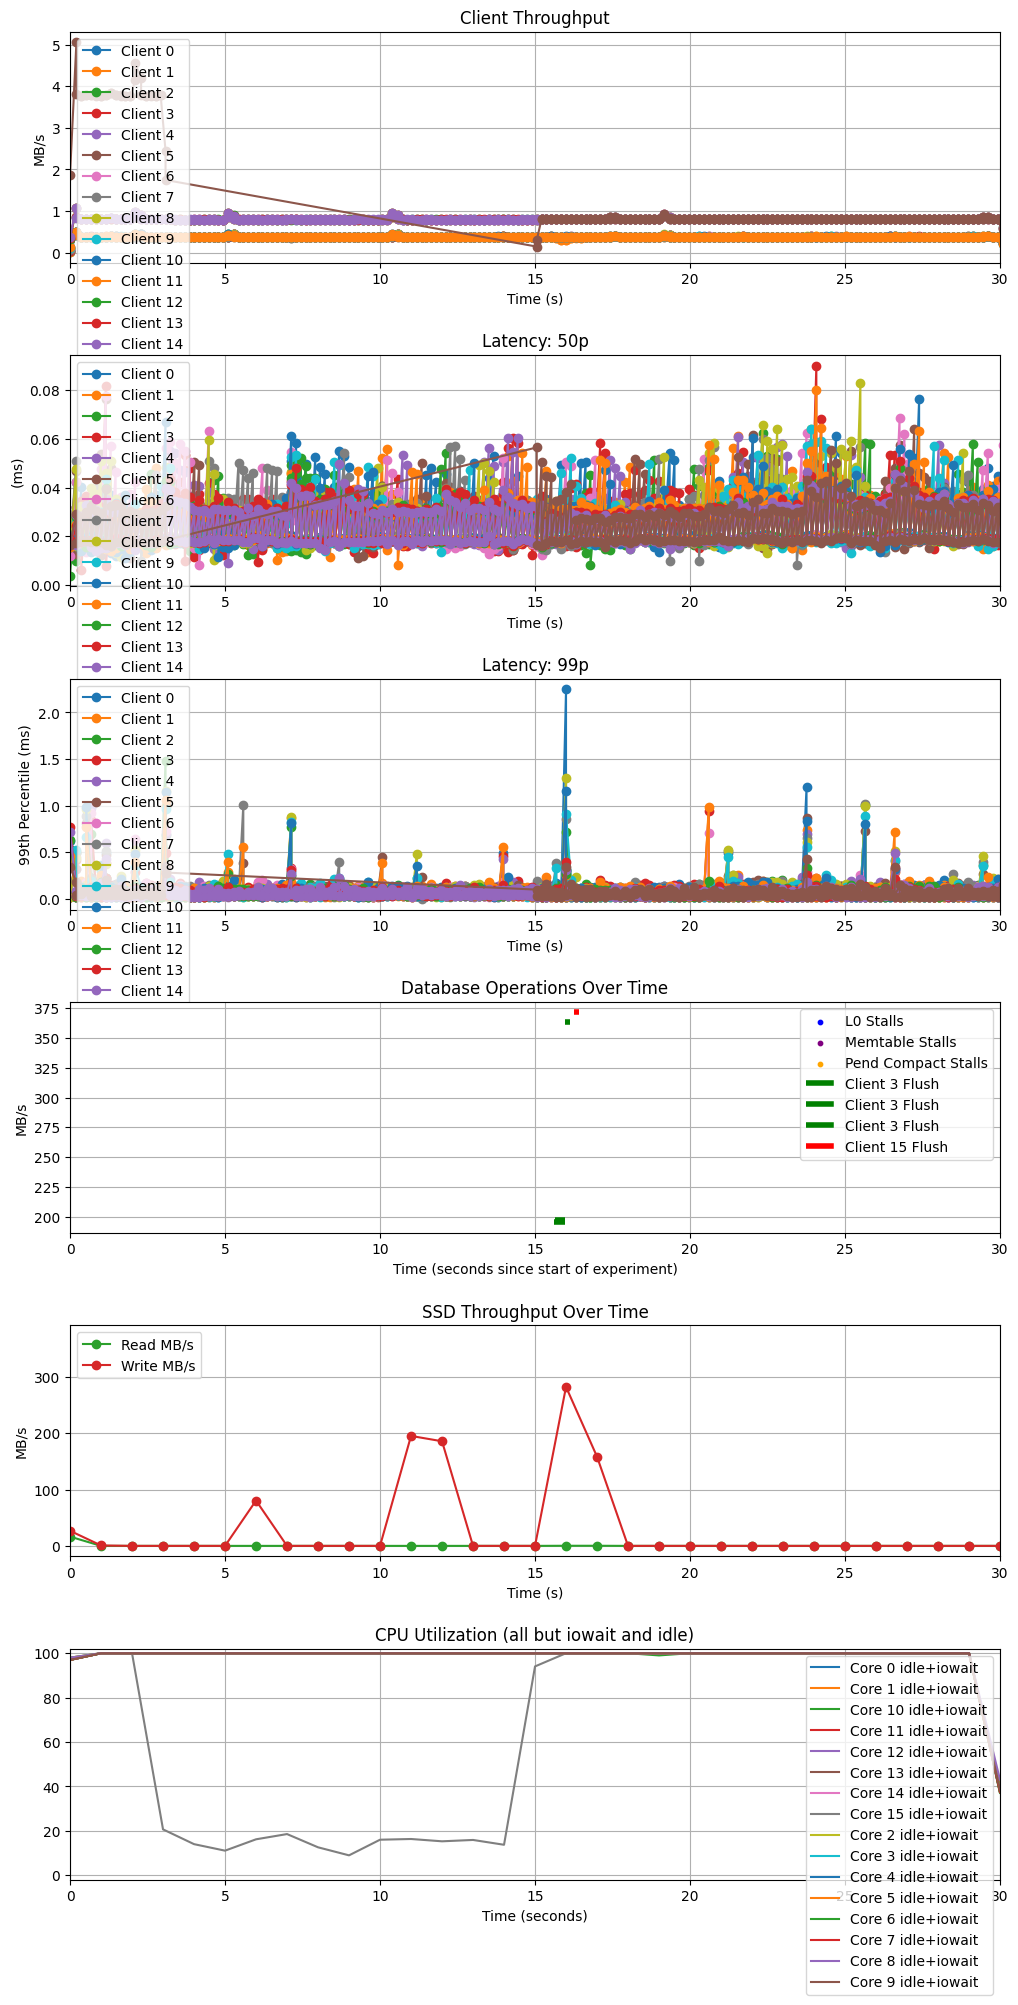

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [187]:
import time 

def generate_plots(xlim, output_file):
  _, axs = plt.subplots(6, 1, figsize=(12, 24))
  plt.subplots_adjust(hspace=0.4)
  start_time_s = plot_client_results(output_file, axs, xlim)
  plot_rocksdb_events(output_file, axs, start_time_s, xlim, (3,0))
  #plot_memtable_stats(output_file, axs, start_time_s, xlim, (4,0))

  start_time_shift = 0
  plot_overall_tputs(output_file, axs, start_time_shift, xlim, (4,0))
  #plot_overall_iops(output_file, axs, start_time_shift, xlim, (5,0))
  #plot_io_waittimes(output_file, axs, start_time_shift, xlim, (6,0))
  #plot_io_reqsize(output_file, axs, start_time_shift, xlim, (6,0))
  plot_cpu_util(output_file, axs, start_time_shift, xlim, (5,0))

  # plot_level_stats(output_file, axs, (10, 0))
  # plot_rsched_stats(output_file, axs, start_time_s, xlim, (10, 11, 12))
  plt.show()

xlim = (0, 30)
output_file = "results/timeseries_" + str(int(time.time())) + ".txt"
generate_plots(xlim, output_file)

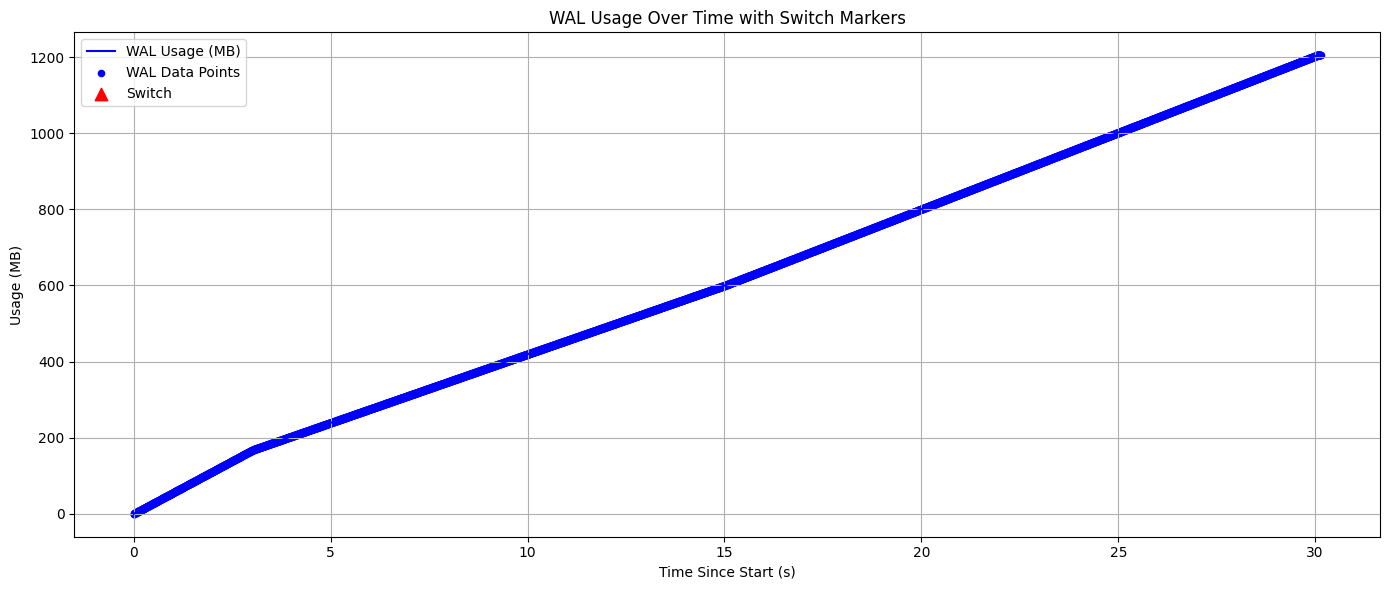

In [188]:
import matplotlib.pyplot as plt
import pandas as pd

# File path
wal_log_path = "logs/WAL_logs.csv"  # Replace with your actual path if needed

# --- Custom Parser for New Format ---
def parse_log(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            operation = parts[0].strip()
            if operation == 'write' and len(parts) >= 4:
                try:
                    data.append({
                        'operation': 'write',
                        'time_in_ms': int(parts[1]),
                        'current_wal_bytes': int(parts[2]),
                        'max_wal_bytes': int(parts[3])
                    })
                except ValueError:
                    continue
            elif operation == 'switch' and len(parts) >= 2:
                try:
                    data.append({
                        'operation': 'switch',
                        'time_in_ms': int(parts[1]),
                        'current_wal_bytes': None,
                        'max_wal_bytes': None
                    })
                except ValueError:
                    continue
    return pd.DataFrame(data)

wal_df = parse_log(wal_log_path)

# Convert time to seconds
wal_df['time_in_s'] = (wal_df['time_in_ms'] - wal_df['time_in_ms'].min()) / 1000

# Separate data
write_df = wal_df[wal_df['operation'] == 'write'].copy()
switch_df = wal_df[wal_df['operation'] == 'switch'].copy()

# --- Plotting ---
fig, ax = plt.subplots(figsize=(14, 6))

# Plot WAL usage trendline
ax.plot(write_df['time_in_s'], write_df['current_wal_bytes'] / (1024 * 1024),
        label='WAL Usage (MB)', color='blue')

# Plot individual data points
ax.scatter(write_df['time_in_s'], write_df['current_wal_bytes'] / (1024 * 1024),
           color='blue', marker='o', s=20, label='WAL Data Points')

# Plot switch markers at y=0
ax.scatter(switch_df['time_in_s'], [0] * len(switch_df),
           color='red', marker='^', s=80, label='Switch', zorder=3)

# Labels and legend
ax.set_xlabel("Time Since Start (s)")
ax.set_ylabel("Usage (MB)")
ax.set_title("WAL Usage Over Time with Switch Markers")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [189]:
from datetime import datetime
from itertools import cycle
import matplotlib.pyplot as plt
import re

# --- Function to plot WAL usage from CSV ---
def plot_wal_usage(ax, wal_csv_path):
    """Plots WAL usage with vertical lines for switches, writes, add_log, and remove_log operations."""
    import pandas as pd

    # --- Custom line-by-line parser for new WAL format ---
    def parse_log(file_path):
        data = []
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                operation = parts[0].strip()

                if operation in ['write', 'switch', 'add_log', 'remove_log']:
                    try:
                        time_in_ms = int(parts[1])
                        current_wal_bytes = int(parts[2]) if operation == 'write' else None
                        max_wal_bytes = int(parts[3]) if operation == 'write' else None

                        data.append({
                            'operation': operation,
                            'time_in_ms': time_in_ms,
                            'current_wal_bytes': current_wal_bytes,
                            'max_wal_bytes': max_wal_bytes
                        })
                    except (ValueError, IndexError):
                        continue  # Skip invalid or malformed lines
        return pd.DataFrame(data)

    # Load parsed data
    df = parse_log(wal_csv_path)

    # Time normalization
    df['time_in_s'] = (df['time_in_ms'] - df['time_in_ms'].min()) / 1000

    # Filter by operation
    switch_df = df[df['operation'] == 'switch']
    write_df = df[df['operation'] == 'write']
    add_log_df = df[df['operation'] == 'add_log']
    remove_log_df = df[df['operation'] == 'remove_log']

    # Plot WAL usage
    ax.plot(write_df['time_in_s'], write_df['current_wal_bytes'] / (1024 * 1024),
            label='WAL Usage (MB)', color='blue')
    
    if not df['max_wal_bytes'].isna().all():
        ax.hlines(y=df['max_wal_bytes'].max() / (1024 * 1024),
                  xmin=df['time_in_s'].min(), xmax=df['time_in_s'].max(),
                  color='orange', label='Max WAL Size (MB)')
    
    ax.scatter(write_df['time_in_s'], write_df['current_wal_bytes'] / (1024 * 1024),
               color='blue', marker='o', s=5, alpha=0.2, label='WAL Data Points')

    # Add vertical lines for key operations
    def add_vertical_lines(df_slice, color, linestyle, label):
        for _, row in df_slice.iterrows():
            ax.axvline(
                x=row['time_in_s'],
                color=color,
                linestyle=linestyle,
                linewidth=2,
                label=label if label not in ax.get_legend_handles_labels()[1] else ""
            )

    add_vertical_lines(switch_df, 'red', 'dotted', 'Switch')
    #add_vertical_lines(add_log_df, 'green', 'dashed', 'Add Log')
    #add_vertical_lines(remove_log_df, 'purple', 'dashdot', 'Remove Log')

    # Labels and legend
    ax.set_xlabel("Time Since Start (s)")
    ax.set_ylabel("WAL Usage (MB)")
    ax.set_title("WAL Data Usage and Operations Over Time")
    ax.legend()
    ax.grid(True)

    # Return the min and max times for external alignment
    return df['time_in_ms'].min(), df['time_in_ms'].max()


# Utility: Convert timestamp string to milliseconds since epoch
def parse_timestamp_to_millis(ts_str):
    dt = datetime.strptime(ts_str, "%Y/%m/%d-%H:%M:%S.%f")
    return int(dt.timestamp() * 1000)

# Sorting helper for Column Families
def cf_sort_key(cf):
    if cf == "default":
        return (0, 0)
    else:
        match = re.search(r'\d+', cf)
        num = int(match.group()) if match else float('inf')
        return (1, num)

# Main flush plotting function
def plot_wal_flushes(output_file, ax, wal_csv_path, log_path, min_time, max_time):
    cf_pattern = re.compile(r'\[(default|cf\d+)\]')
    flush_start_pattern = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}).*?"job": (\d+).*?"flush_reason": ".*"'
    )
    flush_end_pattern = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}).*?JOB (\d+).*?Flush: (\d+) microseconds'
    )
    immutable_memtable_pattern = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}).*?\[(default|cf\d+)\].*?Stopping writes because we have (\d+) immutable memtables'
    )

    cf_flush_starts = {}
    cf_flush_ends = {}
    job_to_cf = {}
    immutable_memtable_events = []

    with open(log_path, 'r') as log_file:
        lines = log_file.readlines()
        prev_cf = "default"

        for line in lines:
            cf_match = cf_pattern.search(line)
            if cf_match:
                prev_cf = cf_match.group(1)

            imm_match = immutable_memtable_pattern.search(line)
            if imm_match:
                timestamp = imm_match.group(1)
                cf = imm_match.group(2)
                count = int(imm_match.group(3))
                ts_millis = parse_timestamp_to_millis(timestamp)

                immutable_memtable_events.append({
                    "cf": cf,
                    "count": count,
                    "timestamp_ms": ts_millis
                })

            start_match = flush_start_pattern.search(line)
            if start_match:
                timestamp = start_match.group(1)
                job_id = start_match.group(2)
                ts_millis = parse_timestamp_to_millis(timestamp)

                if min_time <= ts_millis <= max_time:
                    cf_flush_starts[job_id] = {
                        "time": ts_millis,
                        "cf": prev_cf
                    }
                    job_to_cf[job_id] = prev_cf

            end_match = flush_end_pattern.search(line)
            if end_match:
                timestamp = end_match.group(1)
                job_id = end_match.group(2)
                duration = int(end_match.group(3)) / 1_000_000
                ts_millis = parse_timestamp_to_millis(timestamp)

                if min_time <= ts_millis <= max_time:
                    cf_flush_ends[job_id] = {
                        "end": ts_millis,
                        "duration": duration
                    }

    # Match flush start/end
    cf_flushes = {}
    for job_id, start_info in cf_flush_starts.items():
        if job_id in cf_flush_ends:
            end_time = cf_flush_ends[job_id]["end"]
            duration = cf_flush_ends[job_id]["duration"]

            if start_info["time"] < end_time:
                cf_flushes[job_id] = {
                    "start": start_info["time"],
                    "end": end_time,
                    "cf": start_info["cf"],
                    "duration": duration
                }

    # CF color/y-level setup
    cf_names = sorted(set(f["cf"] for f in cf_flushes.values()), key=cf_sort_key)
    color_cycle = cycle(plt.cm.tab20.colors)
    cf_colors = {cf: next(color_cycle) for cf in cf_names}
    cf_y_levels = {cf: i * -1 for i, cf in enumerate(cf_names)}  # stack downwards

    min_time_seconds = min_time / 1000

    # Plot flush bars
    for job_id, flush in cf_flushes.items():
        start = (flush['start'] - min_time) / 1000
        end = (flush['end'] - min_time) / 1000
        cf = flush['cf']
        color = cf_colors[cf]
        y_level = cf_y_levels[cf]

        ax.hlines(
            y=y_level,
            xmin=start,
            xmax=end,
            color=color,
            linewidth=6,
            label=f'CF: {cf}' if job_id == list(cf_flushes.keys())[0] else ""
        )
        
    # Add flush legend
    handles = [plt.Line2D([0], [0], color=cf_colors[cf], lw=2, label=f'CF: {cf}') for cf in cf_names]
    ax.legend(handles=handles, title="Column Families", loc='lower right')


1747169706996 1747169737135


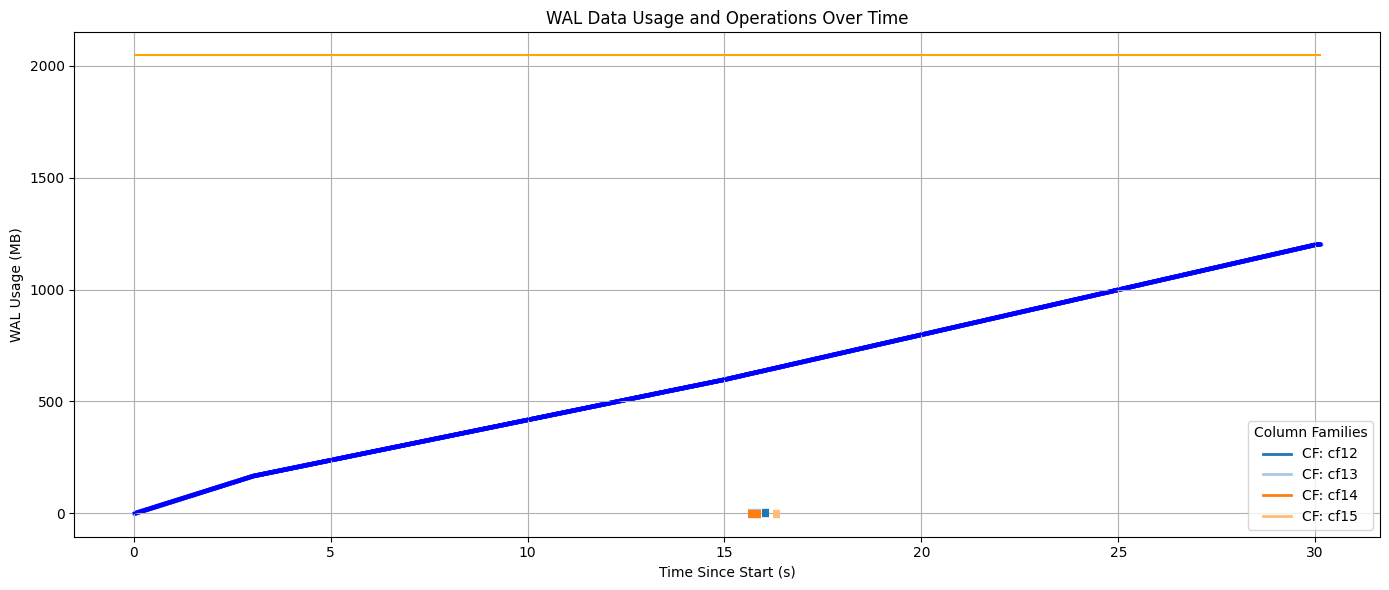

In [190]:
output_file = "flush_output.txt"
wal_csv_path = "logs/WAL_logs.csv"
log_path = "/mnt/rocksdb/ycsb-rocksdb-data/LOG"
# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 6))
# Plot WAL usage and get time range
min_time, max_time = plot_wal_usage(ax, wal_csv_path)
print(min_time, max_time)
# Plot WAL flushes and CF flushes over the WAL graph
plot_wal_flushes(output_file, ax, wal_csv_path, log_path, min_time, max_time)
# Final plot adjustments
plt.tight_layout()
plt.show()

In [191]:
"""
histogram_plots.py

Module to parse a log file and generate 4x4 histograms for flush and compaction durations per column family,
annotated with p50 and p99 latency lines, and to plot aggregate histograms side-by-side.
"""

import matplotlib.pyplot as plt
import numpy as np


def read_log_file(log_file):
    """
    Reads the log file and returns a list of dict entries with keys:
    'operation', 'timestamp', 'cf', 'duration'.
    """
    data = []
    with open(log_file, 'r') as f:
        for line in f:
            parts = [p.strip() for p in line.strip().split(',')]
            if len(parts) != 4:
                continue
            operation, timestamp, cf, duration = parts
            if not operation.endswith('_stats'):
                continue
            try:
                duration = float(duration)
                timestamp = int(timestamp)
            except ValueError:
                continue
            data.append({
                'operation': operation,
                'timestamp': timestamp,
                'cf': cf,
                'duration': duration
            })
    return data


def plot_histograms(data, operation, bins=50):
    """
    Plots a 4x4 grid of histograms of durations for each column family for the specified operation,
    with vertical lines marking the p50 and p99 durations.
    Ordering follows: 'default', 'cf1', 'cf2', ..., 'cf15'.
    """
    # Filter entries for the operation
    durations_by_cf = {}
    for entry in data:
        if entry['operation'] == operation:
            cf = entry['cf']
            durations_by_cf.setdefault(cf, []).append(entry['duration'])

    # Define desired ordering
    desired_cfs = ['cf15'] + ['default'] + [f'cf{i}' for i in range(1, 15)]
    # Select only CFs present
    cfs = [cf for cf in desired_cfs if cf in durations_by_cf]

    if not cfs:
        print(f"No data found for operation: {operation}")
        return

    fig, axes = plt.subplots(4, 4, figsize=(16, 12))
    axes = axes.flatten()

    for ax, cf in zip(axes, cfs):
        durations = durations_by_cf[cf]
        # Compute p50 and p99 latencies
        p50 = np.percentile(durations, 50)
        p99 = np.percentile(durations, 99)
        # Plot histogram
        ax.hist(durations, bins=bins)
        # Annotate p50 and p99
        ax.axvline(p50, linestyle=':', linewidth=1, color='blue')
        ax.axvline(p99, linestyle='--', linewidth=1, color='red')
        ymax = ax.get_ylim()[1]
        ax.text(p50, ymax * 0.9, f'p50: {p50:.2f}', rotation=90,
                color='blue', va='top', ha='left', fontsize='small')
        ax.text(p99, ymax * 0.9, f'p99: {p99:.2f}', rotation=90,
                color='red', va='top', ha='right', fontsize='small')

        ax.set_title(cf)
        ax.set_xlabel('Duration')
        ax.set_ylabel('Count')

    # Turn off any unused subplots
    for ax in axes[len(cfs):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_flush_histograms(log_file, bins=50):
    """
    Reads the log file and plots flush_stats histograms with p50 and p99 annotations.
    """
    data = read_log_file(log_file)
    plot_histograms(data, 'flush_stats', bins=bins)


def plot_compaction_histograms(log_file, bins=50):
    """
    Reads the log file and plots compaction_stats histograms with p50 and p99 annotations.
    """
    data = read_log_file(log_file)
    plot_histograms(data, 'compaction_stats', bins=bins)

def plot_flush_queue_histograms(log_file, bins=50):
    """
    Reads the log file and plots flush_stats histograms with p50 and p99 annotations.
    """
    data = read_log_file(log_file)
    plot_histograms(data, 'flush_queue_stats', bins=bins)

def plot_compaction_queue_histograms(log_file, bins=50):
    """
    Reads the log file and plots compaction_stats histograms with p50 and p99 annotations.
    """
    data = read_log_file(log_file)
    plot_histograms(data, 'compaction_queue_stats', bins=bins)


def plot_aggregate_histograms(log_file, bins=50):
    """
    Reads the log file and plots aggregate histograms for flush_stats and compaction_stats
    side-by-side (1x2), each annotated with p50 and p99 latencies.
    """
    data = read_log_file(log_file)
    # Gather durations for each operation
    flush_durations = [entry['duration'] for entry in data if entry['operation'] == 'flush_stats']
    compaction_durations = [entry['duration'] for entry in data if entry['operation'] == 'compaction_stats']

    if not flush_durations and not compaction_durations:
        print("No data found for flush_stats or compaction_stats")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Flush histogram
    if flush_durations:
        p50_flush = np.percentile(flush_durations, 50)
        p99_flush = np.percentile(flush_durations, 99)
        axes[0].hist(flush_durations, bins=bins)
        axes[0].axvline(p50_flush, linestyle=':', linewidth=1, color='blue')
        axes[0].axvline(p99_flush, linestyle='--', linewidth=1, color='red')
        ymax = axes[0].get_ylim()[1]
        axes[0].text(p50_flush, ymax * 0.9, f'p50: {p50_flush:.2f}', rotation=90,
                     color='blue', va='top', ha='left', fontsize='small')
        axes[0].text(p99_flush, ymax * 0.9, f'p99: {p99_flush:.2f}', rotation=90,
                     color='red', va='top', ha='right', fontsize='small')
    axes[0].set_title('Aggregate Flush Durations')
    axes[0].set_xlabel('Duration')
    axes[0].set_ylabel('Count')

    # Compaction histogram
    if compaction_durations:
        p50_comp = np.percentile(compaction_durations, 50)
        p99_comp = np.percentile(compaction_durations, 99)
        axes[1].hist(compaction_durations, bins=bins)
        axes[1].axvline(p50_comp, linestyle=':', linewidth=1, color='blue')
        axes[1].axvline(p99_comp, linestyle='--', linewidth=1, color='red')
        ymax = axes[1].get_ylim()[1]
        axes[1].text(p50_comp, ymax * 0.9, f'p50: {p50_comp:.2f}', rotation=90,
                     color='blue', va='top', ha='left', fontsize='small')
        axes[1].text(p99_comp, ymax * 0.9, f'p99: {p99_comp:.2f}', rotation=90,
                     color='red', va='top', ha='right', fontsize='small')
    axes[1].set_title('Aggregate Compaction Durations')
    axes[1].set_xlabel('Duration')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

def plot_aggregate_queue_histograms(log_file, bins=50):
    """
    Reads the log file and plots aggregate histograms for flush_stats and compaction_stats
    side-by-side (1x2), each annotated with p50 and p99 latencies.
    """
    data = read_log_file(log_file)
    # Gather durations for each operation
    flush_durations = [entry['duration'] for entry in data if entry['operation'] == 'flush_queue_stats']
    compaction_durations = [entry['duration'] for entry in data if entry['operation'] == 'compaction_queue_stats']

    if not flush_durations and not compaction_durations:
        print("No data found for flush_stats or compaction_stats")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Flush histogram
    if flush_durations:
        p50_flush = np.percentile(flush_durations, 50)
        p99_flush = np.percentile(flush_durations, 99)
        axes[0].hist(flush_durations, bins=bins)
        axes[0].axvline(p50_flush, linestyle=':', linewidth=1, color='blue')
        axes[0].axvline(p99_flush, linestyle='--', linewidth=1, color='red')
        ymax = axes[0].get_ylim()[1]
        axes[0].text(p50_flush, ymax * 0.9, f'p50: {p50_flush:.2f}', rotation=90,
                     color='blue', va='top', ha='left', fontsize='small')
        axes[0].text(p99_flush, ymax * 0.9, f'p99: {p99_flush:.2f}', rotation=90,
                     color='red', va='top', ha='right', fontsize='small')
    axes[0].set_title('Aggregate Flush Queue Durations')
    axes[0].set_xlabel('Duration')
    axes[0].set_ylabel('Count')

    # Compaction histogram
    if compaction_durations:
        p50_comp = np.percentile(compaction_durations, 50)
        p99_comp = np.percentile(compaction_durations, 99)
        axes[1].hist(compaction_durations, bins=bins)
        axes[1].axvline(p50_comp, linestyle=':', linewidth=1, color='blue')
        axes[1].axvline(p99_comp, linestyle='--', linewidth=1, color='red')
        ymax = axes[1].get_ylim()[1]
        axes[1].text(p50_comp, ymax * 0.9, f'p50: {p50_comp:.2f}', rotation=90,
                     color='blue', va='top', ha='left', fontsize='small')
        axes[1].text(p99_comp, ymax * 0.9, f'p99: {p99_comp:.2f}', rotation=90,
                     color='red', va='top', ha='right', fontsize='small')
    axes[1].set_title('Aggregate Compaction Queue Durations')
    axes[1].set_xlabel('Duration')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()



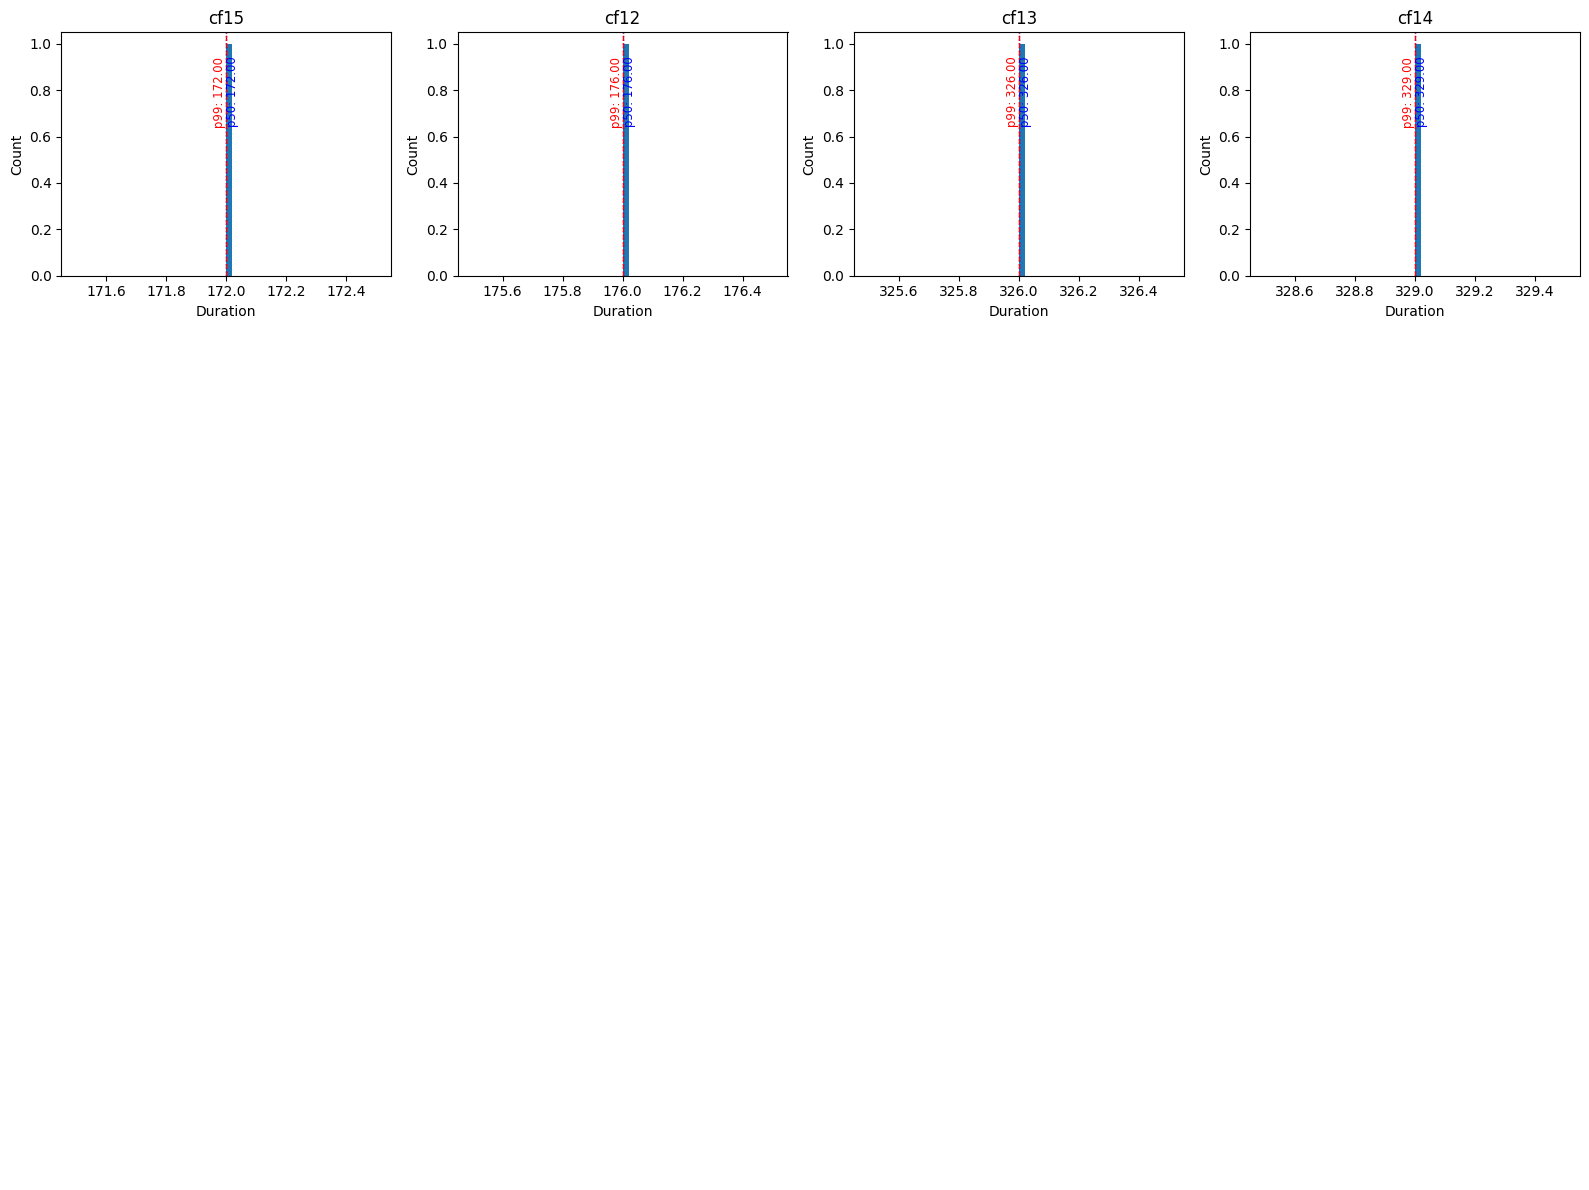

In [192]:
plot_flush_histograms("logs/WAL_logs.csv")

In [193]:
plot_compaction_histograms("logs/WAL_logs.csv")

No data found for operation: compaction_stats


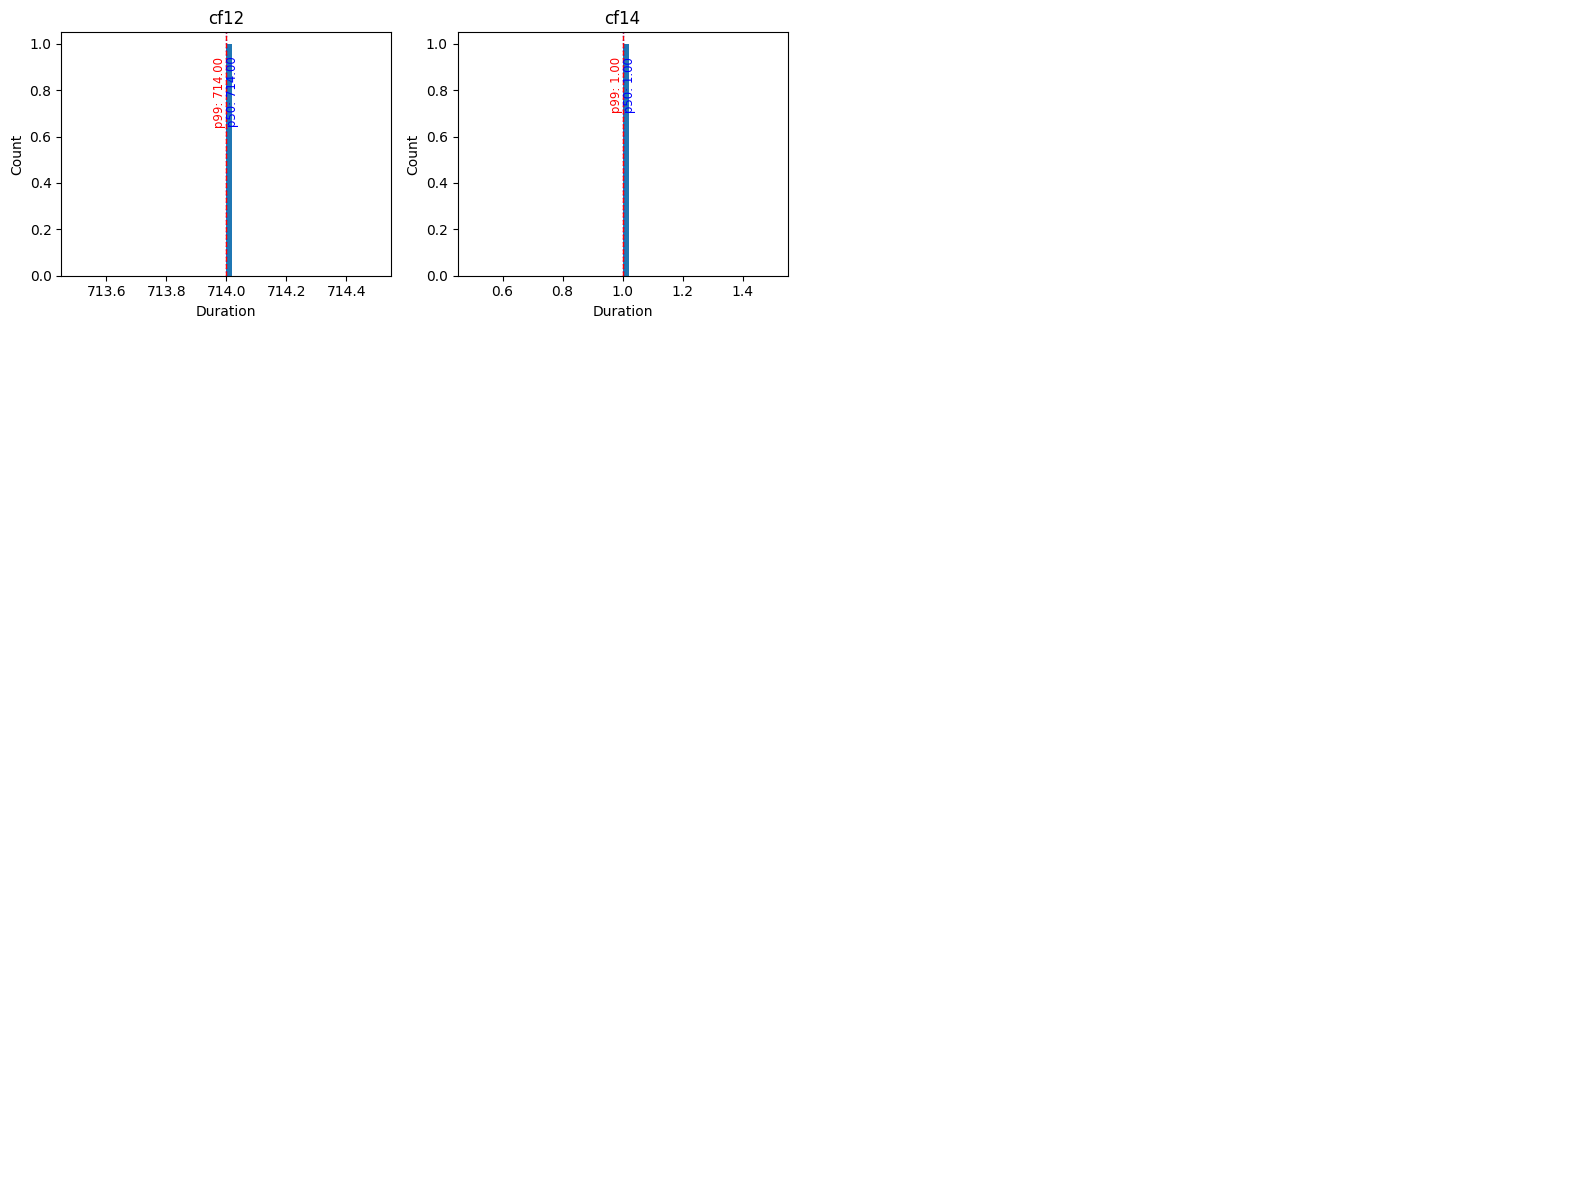

In [194]:
plot_flush_queue_histograms("logs/WAL_logs.csv")

In [195]:
plot_compaction_queue_histograms("logs/WAL_logs.csv")

No data found for operation: compaction_queue_stats


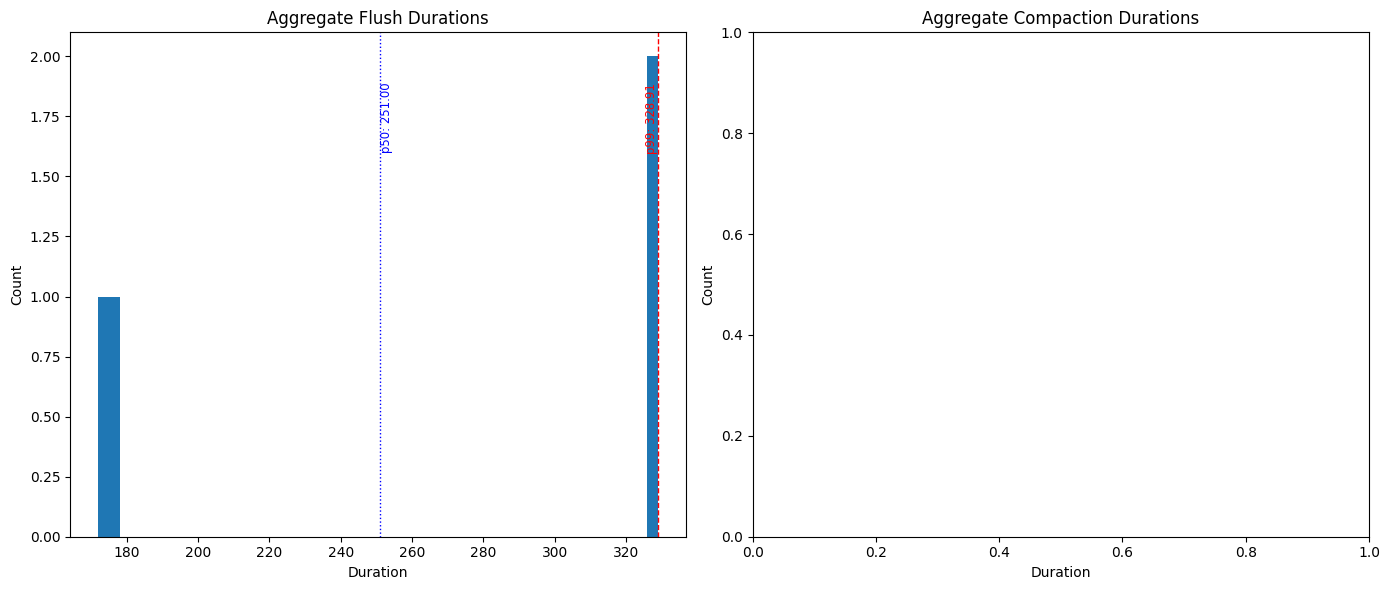

In [196]:
plot_aggregate_histograms("logs/WAL_logs.csv")

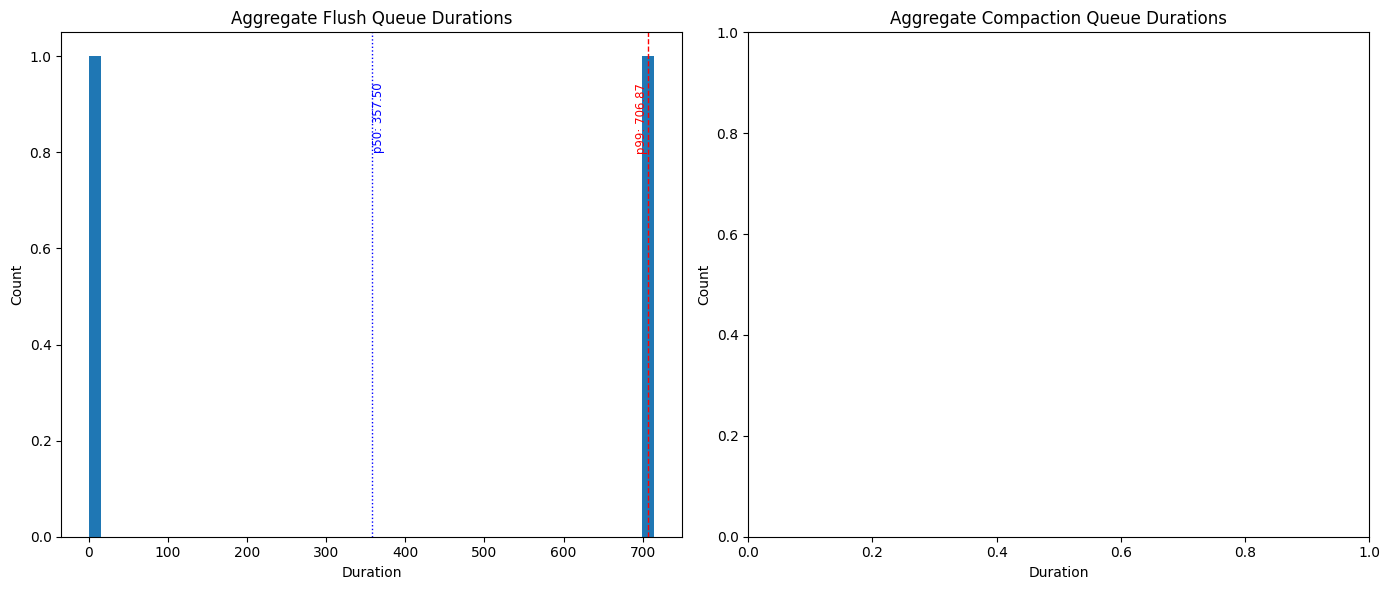

In [197]:
plot_aggregate_queue_histograms("logs/WAL_logs.csv")

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_credit_stats_from_log(file_path):
    data = []

    # Parse log lines
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith("credit_stats"):
                parts = line.strip().split(", ")
                if len(parts) == 7:
                    try:
                        timestamp = int(parts[1])
                        cf_name = parts[2]
                        credit_ms = float(parts[3])
                        data.append((timestamp, cf_name, credit_ms))
                    except ValueError:
                        continue  # skip malformed entries

    if not data:
        print("No credit_stats lines found.")
        return

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["timestamp", "cf_name", "credit_ms"])

    # Normalize time to seconds since first timestamp
    first_timestamp = df["timestamp"].min()
    df["time_s"] = (df["timestamp"] - first_timestamp) / 1000.0

    # Pivot table to handle duplicates
    pivot_df = df.pivot_table(index="time_s", columns="cf_name", values="credit_ms", aggfunc='mean')

    # Set up plot size
    plt.figure(figsize=(14, 6))  # Wider plot

    # Plot the data
    pivot_df.plot(marker='o', ax=plt.gca())

    # Y-axis lower limit based on cf15
    if 'cf15' in pivot_df.columns:
        min_cf15 = pivot_df['cf15'].min()
        plt.ylim(bottom=min_cf15 * 1.2)
        max_cf15 = pivot_df['cf15'].max()
        plt.ylim(top=max_cf15 * 1.2)

    plt.title("DFS Credit Over Time")
    plt.xlabel("Time (seconds since first entry)")
    plt.ylabel("DFS Credit (ms)")
    plt.legend(title="Column Family")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [199]:
plot_credit_stats_from_log("logs/WAL_logs.csv")

No credit_stats lines found.


In [200]:
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle
import re # Import regex module

def parse_wal_and_attribution(log_path):
    write_data = []
    attribution_data = []
    switch_data = []
    flush_queue_data = [] # New list for flush queue data

    # Regex to extract reason from flush queue details - Updated!
    # Capture characters after 'Reason:' until the next comma
    reason_regex = re.compile(r"Reason:([^,]+)")

    with open(log_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            op = parts[0].strip()

            if op == 'write' and len(parts) >= 4:
                try:
                    write_data.append({
                        'time_in_ms': int(parts[1]),
                        'current_wal_bytes': int(parts[2]),
                        'max_wal_bytes': int(parts[3])
                    })
                except:
                    continue
            elif op == 'switch':
                try:
                    switch_data.append({
                        'time_in_ms': int(parts[1])
                    })
                except:
                    continue
            elif op == 'attribution' and len(parts) >= 3:
                try:
                    time_in_ms = int(parts[1])
                    raw_kv_str = parts[2].strip().strip('"')
                    kv_pairs = raw_kv_str.split()
                    kv_dict = {'time_in_ms': time_in_ms}
                    for pair in kv_pairs:
                        key, val = pair.split(':')
                        kv_dict[key] = int(val)
                    attribution_data.append(kv_dict)
                except:
                    continue
            elif op == 'flush_queue' and len(parts) >= 5:
                try:
                    time_in_ms = int(parts[2])
                    total_requests = int(parts[3])
                    primary_details_str = parts[4]
                    secondary_details_str = parts[5] if len(parts) > 5 else ""
            
                    # Count number of entries by counting `{Reason:` substrings
                    primary_queue_size = primary_details_str.count("{Reason:")
                    secondary_queue_size = secondary_details_str.count("{Reason:")

            
                    # Extract reasons as before
                    full_details_str = ",".join(parts[4:])
                    reasons = reason_regex.findall(full_details_str)
                    reasons = [r.strip() for r in reasons]
                    reason_counts = {r: reasons.count(r) for r in set(reasons)}
            
                    flush_entry = {
                        'time_in_ms': time_in_ms,
                        'total_requests': total_requests,
                        'primary_queue_size': primary_queue_size,
                        'secondary_queue_size': secondary_queue_size,
                        'combined_queue_size': primary_queue_size + secondary_queue_size  # new!
                    }

                    flush_entry.update(reason_counts)
                    flush_queue_data.append(flush_entry)
            
                except Exception as e:
                    print(f"Error parsing flush_queue line: {line.strip()} - {e}")
                    continue
                


    write_df = pd.DataFrame(write_data)
    attr_df = pd.DataFrame(attribution_data)
    switch_df = pd.DataFrame(switch_data)
    flush_queue_df = pd.DataFrame(flush_queue_data) # Create DataFrame

    if not attr_df.empty:
        attr_df.fillna(0, inplace=True)
    if not flush_queue_df.empty:
        flush_queue_df.fillna(0, inplace=True) # Fill NaN reason counts with 0


    # --- Time Normalization ---
    all_min_times = []
    if not write_df.empty: all_min_times.append(write_df['time_in_ms'].min())
    if not attr_df.empty: all_min_times.append(attr_df['time_in_ms'].min())
    if not flush_queue_df.empty: all_min_times.append(flush_queue_df['time_in_ms'].min())
    if not switch_df.empty: all_min_times.append(switch_df['time_in_ms'].min())

    if not all_min_times: # Handle case where all inputs might be empty
        print("Warning: No valid time data found in logs.")
        min_time = 0
    else:
        min_time = min(all_min_times)


    if not write_df.empty:
        write_df['time_in_s'] = (write_df['time_in_ms'] - min_time) / 1000
    if not attr_df.empty:
        attr_df['time_in_s'] = (attr_df['time_in_ms'] - min_time) / 1000
    if not switch_df.empty:
        switch_df['time_in_s'] = (switch_df['time_in_ms'] - min_time) / 1000
    if not flush_queue_df.empty:
        flush_queue_df['time_in_s'] = (flush_queue_df['time_in_ms'] - min_time) / 1000
        # Ensure time is sorted for plotting
        flush_queue_df.sort_values('time_in_s', inplace=True)


    return write_df, attr_df, switch_df, flush_queue_df # Return the new df


def plot_attribution_and_wal(write_df, attr_df, switch_df, flush_queue_df, x_min=None, x_max=None): # Add flush_queue_df
    # Increase number of subplots to 4
    fig, axs = plt.subplots(3, 1, figsize=(14, 16), sharex=True) # Increased height

    # Use a color cycle to assign unique colors to CFs and Reasons
    color_cycle = cycle(plt.cm.tab20.colors) # Reset color cycle for consistency if needed
    cf_colors = {}
    if not attr_df.empty:
        cf_colors = {key: next(color_cycle) for key in attr_df.columns if key not in ['time_in_ms', 'time_in_s', 'sum_attr_bytes']}

    color_cycle_2 = cycle(plt.cm.tab20.colors)
    reason_colors = {}
    if not flush_queue_df.empty:
        reason_cols = [col for col in flush_queue_df.columns if col not in ['time_in_ms', 'time_in_s', 'total_requests']]
        reason_colors = {key: next(color_cycle_2) for key in reason_cols}


    # --- Plot 1: Individual attribution keys ---
    if not attr_df.empty:
        for key in attr_df.columns:
            if key not in ['time_in_ms', 'time_in_s', 'sum_attr_bytes']:
                 # Check if the column actually exists before plotting
                 if key in attr_df:
                    axs[0].plot(attr_df['time_in_s'], attr_df[key] / (1024 * 1024),
                               label=f'CF {key}', color=cf_colors.get(key, next(color_cycle))) # Use get for safety

    axs[0].set_ylabel("Attribution Value (MB)")
    axs[0].set_title("Attribution Key Values Over Time")
    axs[0].legend()
    axs[0].grid(True)

    # --- Plot 2: Write vs Attribution Sum ---
    if not attr_df.empty:
        attr_df['sum_attr_bytes'] = attr_df.drop(columns=['time_in_ms', 'time_in_s'], errors='ignore').sum(axis=1)
    else:
        # Create dummy column if attr_df is empty to avoid errors later
        attr_df['sum_attr_bytes'] = 0

    # Plot WAL usage
    if not write_df.empty:
        axs[1].plot(write_df['time_in_s'], write_df['current_wal_bytes'] / (1024 * 1024),
                    label='WAL Usage (MB)', color='blue')

        # Plot max WAL size
        if 'max_wal_bytes' in write_df.columns and not write_df['max_wal_bytes'].isna().all():
            axs[1].hlines(y=write_df['max_wal_bytes'].max() / (1024 * 1024),
                          xmin=write_df['time_in_s'].min(), xmax=write_df['time_in_s'].max(),
                          color='orange', label='Max WAL Size (MB)')

    # Plot attribution sum
    if not attr_df.empty and 'sum_attr_bytes' in attr_df.columns:
        axs[1].plot(attr_df['time_in_s'], attr_df['sum_attr_bytes'] / (1024 * 1024),
                    label='Sum of Attribution (MB)', color='green')

    # Add vertical lines for WAL switches
    if not switch_df.empty:
        switch_labels_added = set()
        for _, row in switch_df.iterrows():
             label = 'Switch' if 'Switch' not in switch_labels_added else ""
             axs[1].axvline(
                 x=row['time_in_s'],
                 color='red',
                 linestyle='dotted',
                 linewidth=2,
                 label=label
             )
             if label: switch_labels_added.add('Switch')


    axs[1].set_ylabel("Bytes (MB)")
    axs[1].set_title("WAL Write vs Attribution Total")
    axs[1].legend()
    axs[1].grid(True)

    # --- Plot 3: % Difference ---
    percent_diff = pd.Series(dtype=float) # Initialize empty series
    aligned_attr = pd.DataFrame() # Initialize empty df

    if not write_df.empty and not attr_df.empty and 'sum_attr_bytes' in attr_df.columns:
        # Align attribution sum to write times using merge_asof
        aligned_attr = pd.merge_asof(
            write_df[['time_in_s', 'current_wal_bytes']].sort_values('time_in_s'),
            attr_df[['time_in_s', 'sum_attr_bytes']].sort_values('time_in_s'),
            on='time_in_s',
            direction='nearest',
            tolerance=0.5  # seconds
        )

        # Drop rows where attribution didn't align or WAL bytes are zero/NaN
        aligned_attr.dropna(subset=['sum_attr_bytes', 'current_wal_bytes'], inplace=True)
        aligned_attr = aligned_attr[aligned_attr['current_wal_bytes'] > 0] # Avoid division by zero

        # Filter out first few seconds to avoid logging delays
        aligned_attr = aligned_attr[aligned_attr['time_in_s'] > 5]

        if not aligned_attr.empty:
            percent_diff = 100 * (
                (aligned_attr['current_wal_bytes'] - aligned_attr['sum_attr_bytes']) /
                aligned_attr['current_wal_bytes']
            )

    # Only plot if there's data
    if not aligned_attr.empty and not percent_diff.empty:
         axs[2].plot(aligned_attr['time_in_s'], percent_diff,
                     label='% Difference (Write - Attribution)', color='purple') # Changed color

    axs[2].set_ylabel("Percent Difference (%)")
    axs[2].set_title("Percent Difference Between WAL Write and Attribution Sum")
    axs[2].legend()
    axs[2].grid(True)


# # --- Plot 4: Flush Queue State ---
# if not flush_queue_df.empty:
#     reason_cols = sorted([
#         col for col in flush_queue_df.columns 
#         if col not in ['time_in_ms', 'time_in_s', 'total_requests', 
#                        'primary_queue_size', 'secondary_queue_size', 'combined_queue_size']
#     ])
    
#     # Stackplot: Reason breakdown
#     if reason_cols:
#         y_stack = [flush_queue_df[col] for col in reason_cols]
#         stack_labels = [f"Reason: {col}" for col in reason_cols]
#         stack_colors = [reason_colors.get(col, next(color_cycle)) for col in reason_cols]

#         axs[3].stackplot(flush_queue_df['time_in_s'], y_stack,
#                          labels=stack_labels, colors=stack_colors, alpha=0.5)

#     # Line: Secondary queue size
#     if 'secondary_queue_size' in flush_queue_df:
#         axs[3].plot(flush_queue_df['time_in_s'], flush_queue_df['secondary_queue_size'],
#                     label='Secondary Queue Size', color='blue', linewidth=2)

#     # Line: Combined queue size
#     if 'combined_queue_size' in flush_queue_df:
#         axs[3].plot(flush_queue_df['time_in_s'], flush_queue_df['combined_queue_size'],
#                     label='Total Queue Size (Primary + Secondary)', color='red', linewidth=2)

#     axs[3].set_xlabel("Time Since Start (s)")
#     axs[3].set_ylabel("Number of Flush Requests")
#     axs[3].set_title("Flush Queue Size and Composition Over Time")
#     axs[3].legend()
#     axs[3].grid(True)



    # Set x-axis limits if provided
    if x_min is not None and x_max is not None:
        for ax in axs:
            # Check if axis has data before setting limits
            if ax.has_data():
                ax.set_xlim(x_min, x_max)

    plt.tight_layout()
    plt.show()


In [201]:
# Add a call to the above function
#write_df, attr_df, switch_df, queue_df = parse_wal_and_attribution("logs/WAL_logs.csv")
#plot_attribution_and_wal(write_df, attr_df, switch_df, queue_df)